# HR Analytics & Predictive Modeling for Employee Attrition

In [2]:
# data analysis
import numpy as np
import pandas as pd

from category_encoders import MEstimateEncoder, TargetEncoder
from category_encoders.woe import WOEEncoder
from patsy import dmatrices
from scipy.stats import chi2_contingency, pointbiserialr
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Feature Importance
from boruta import BorutaPy

# Over Sampling Technique
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# system operations
import sys

# load ML code
sys.path.insert(0, './')
%load_ext autoreload
%autoreload 2

# pandas display options
pd.options.display.float_format = '{:,.3f}'.format
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# review environment
print(sys.version)
print(np.__version__)
print(pd.__version__)
print(sns.__version__)

3.13.1 | packaged by Anaconda, Inc. | (main, Dec 11 2024, 10:35:08) [Clang 14.0.6 ]
2.2.0
2.2.3
0.13.2


In [3]:
# utilities

def woe_encode_cat_feats_with_contigency_table(data_df, target, multi_cat_feats_list, regularization=1.0, verbose=False):
    '''
    1. Encodes categorical features found in multi_cat_feats_list using Weight of Evidence encoding.
    
    2. For the same features it creates a contigency table having the amount of positive, negative
    and total instances for each feature category A positive instance is one for which the
    dependent/target variable is equal to 1 or "Yes", a negative is one for which the target
    variable is 0 or "No". Also, this table has the empirical probabilities for each category given
    the target is 1 (positive) or 0 (negative). Lastly, the weight of evidence (WOE) and information
    value (IV) are calculated for each category. All calucations are done based on the Pandas DataFrame
    data_df holding the data.

    Returns the contigency table. The original DataFrame is updated in-place with the encoded data.
    '''

    enc = WOEEncoder(verbose=1, cols=multi_cat_feats_list).fit(data_df[multi_cat_feats_list], data_df[target], regularization=regularization)
    encoded = enc.transform(data_df[multi_cat_cols_list])
    data_df[multi_cat_feats_list] = encoded
    
    total_positive = data_df[target].sum()
    total_negative = len(data_df) - total_positive
    cols = ['Feature', 'Category', 'Positive', 'Negative', 'Total', 'Prob(Category|Target=1)', 'Prob(Category|Target=0)', 'WOE', 'IV']
    contigency_tables_df = pd.DataFrame(columns=cols)
    for feat in multi_cat_feats_list:
        feat_ord_scores_pds = [x['mapping'] for x in enc.ordinal_encoder.mapping if x['col'] == feat][0]
        # drop nan key added by the encoder since our data have no nan
        feat_woe_scores_dict = {woe : original_cat for (idx, woe) in enc.mapping[feat].items()
                                for (original_cat, ordinal_idx) in feat_ord_scores_pds.items()
                                if idx == ordinal_idx and isinstance(original_cat, str)}

        # contigency table
        contigency_df = data_df.groupby(feat)[target].agg(Positive='sum', Total='count').reset_index()
        contigency_df['Negative'] = contigency_df['Total'] - contigency_df['Positive']
        contigency_df['Feature'] = feat
        contigency_df['Category'] = [feat_woe_scores_dict[x] for x in contigency_df[feat]]
        # calculate proportions
        contigency_df['Prob(Category|Target=1)'] = contigency_df['Positive'] / total_positive
        contigency_df['Prob(Category|Target=0)'] = contigency_df['Negative'] / total_negative
        # the feature values are encoded using their woe scores, so we use them directly
        contigency_df['WOE'] = contigency_df[feat]
        contigency_df['IV'] = (contigency_df['Prob(Category|Target=1)'] - contigency_df['Prob(Category|Target=0)']) * contigency_df[feat]
        # update
        contigency_df = contigency_df[cols]
        if len(contigency_tables_df) == 0:
            contigency_tables_df = contigency_df
        else:
            contigency_tables_df = pd.concat([contigency_tables_df, contigency_df], ignore_index=True)

        if verbose:
            print('->', '{0: <15}'.format(feat), 'Information Value:', '{0:.3f}'.format(contigency_df['IV'].sum())
                  , '\nclasses:', '{0: <20}'.format(str(list(feat_woe_scores_dict.values())))
                  , 'encoded as:', ['{0:.3f}'.format(vl) for vl in feat_woe_scores_dict.keys()])

    return contigency_tables_df


def plot_cat_feats_by_iv_ranking(contigency_tables_df):
    '''
    Plots categorical features found in contigency_tables_df Pandas DataFrame
    ranked by their information value (IV) value in descending order.
    '''
    feat_ivs_df = contigency_tables_df.groupby('Feature')['IV'].agg(IV='sum').sort_values('IV', ascending=False)
    iv_thresholds_list = [0, 0.02, .1, .3, .5]
    clr_palette = sns.color_palette('crest_r', n_colors=len(feat_ivs_df), desat=1)
    plt.figure(figsize=(8, 5))
    ax = sns.barplot(data=feat_ivs_df, y='IV', x='Feature', hue='Feature', palette=clr_palette)
    
    # set x, y axis properties
    ax.set(ylim=(0, .6))
    ax.tick_params(labelsize=11, labelcolor=[0, 0, 0, 0.5])
    ax.get_yaxis().set_visible(False)
    
    # annotate with iv values
    for i, p in enumerate(ax.patches):
        h, w, x, y = p.get_height(), p.get_width(), p.get_x(), p.get_y()
        xy = (x + w/2., y + h/2)
        text = '{0:0.3f}'.format(feat_ivs_df['IV'].iloc[i])
        ax.annotate(text=text, xy=xy, ha='center', va='center', color='white', size=11, weight='bold')
    
    # show IV thresholds
    leg = ax.legend(['< 0.02 useless', '< 0.1 weak', '< 0.3 medium', '<= 0.5 strong', '> 0.5 suspicious']
                    , ncol=1, loc='best', frameon=False, fontsize='medium', labelcolor=[0, 0, 0, 0.5]
                    , title='Predictive Power Scale')
    # lighten legend bullet points
    for lh in leg.legend_handles:
        lh.set_alpha(0.5)
    leg.get_title().set_alpha(0.5)
        
    # ax title
    ax.set_title('Multi-value categorical features ranked by predictive power (IV)')
    # remove clutter
    sns.despine(left=True, bottom=True)


def plot_cat_feat_woe_iv(feat, contigency_tables_df, figsize=(10, 5)):
    '''
    Plots a categorical feature against its weight of evidence (WOE) and
    information value (IV).
    '''

    feat_df = contigency_tables_df[contigency_tables_df['Feature'] == feat].copy()
    feat_df['Not Leave %'] = feat_df['Negative'] / feat_df['Total']

    rows, cols = 1, 2
    fig, axes = plt.subplots(rows, cols, sharey=True, figsize=figsize)
    
    sns.set_color_codes('muted')
    sns.barplot(data=feat_df, x='WOE', y='Category', color='b', ax=axes[0])
    axes[0].set_title('Weight of Evidence (WoE) by ' + feat)
    axes[0].set_ylabel('')
    
    sns.barplot(data=feat_df, x='IV', y='Category', color='b', ax=axes[1])
    axes[1].set_title('Information Value (IV) Contribution by ' + feat)
    
    sns.despine(left=True, bottom=True)


def plot_target_by_cat_feat(target, feat, contigency_tables_df, figsize=(10, 5)):
    '''
    Plots data dependent variable aka target against a categorical feature both
    using absolute and relative values.
    '''

    
    feat_df = contigency_tables_df[contigency_tables_df['Feature'] == feat].copy()
    feat_df['Not Leave %'] = feat_df['Negative'] / feat_df['Total']
    feat_df['Total %'] = 1
    
    rows, cols = 1, 2
    fig, axes = plt.subplots(rows, cols, sharey=True, figsize=figsize)
    sns.set_color_codes('pastel')
    sns.barplot(data=feat_df, y='Category', x='Total', orient='h', color='b', label='Yes', ax=axes[0])
    sns.set_color_codes('muted')
    sns.barplot(data=feat_df, y='Category', x='Negative', orient='h', color='b', label='No', ax=axes[0])
    
    # annotate with values
    for i, p in enumerate(axes[0].patches[: len(feat_df)]):
        h, w, x, y = p.get_height(), p.get_width(), p.get_x(), p.get_y()
        xy = (x + w/3., y + h/2)
        text = '{0:d}'.format(feat_df['Negative'].iloc[i])
        axes[0].annotate(text=text, xy=xy, ha='center', va='center', color='white', size=11, weight='bold')
        xy = (x + .87 * w, y + h/2)
        if feat_df['Not Leave %'].iloc[i] < .9:
            text = '{0:d}'.format((feat_df['Positive'].iloc[i]))
            axes[0].annotate(text=text, xy=xy, ha='center', va='center', color='white', size=11, weight='bold')
        xy = (16 + w, y + h/2)
        text = '{0:d}'.format((feat_df['Total'].iloc[i]))
        axes[0].annotate(text=text, xy=xy, ha='center', va='center', color=[0, 0, 0, 0.3], size=11, weight='bold')
    
    axes[0].set_title(target + ' by ' + feat)
    axes[0].set_xlabel('')
    axes[0].set_xticks([])
    axes[0].set_ylabel('');
    axes[0].legend(title=target, ncol=1, frameon=False, bbox_to_anchor=(1, 1))
    
    sns.set_color_codes('pastel')
    sns.barplot(data=feat_df, y='Category', x='Total %', orient='h', color='b', ax=axes[1])
    sns.set_color_codes('muted')
    sns.barplot(data=feat_df, y='Category', x='Not Leave %', orient='h', color='b', ax=axes[1])
    
    for i, p in enumerate(axes[1].patches[: len(feat_df)]):
        h, w, x, y = p.get_height(), p.get_width(), p.get_x(), p.get_y()
        xy = (x + w/3., y + h/2)
        text = '{0:2.1f}'.format(100 * feat_df['Not Leave %'].iloc[i]) + '%'
        axes[1].annotate(text=text, xy=xy, ha='center', va='center', color='white', size=11, weight='bold')
        xy = (x + .9 * w, y + h/2)
        if feat_df['Not Leave %'].iloc[i] < .9:
            text = '{0:2.1f}'.format(100 * (1 - feat_df['Not Leave %'].iloc[i])) + '%'
            axes[1].annotate(text=text, xy=xy, ha='center', va='center', color='white', size=11, weight='bold')
    
    sns.despine(left=True, bottom=True)
    
    axes[1].set_title(target + ' % by ' + feat)
    axes[1].set_xlabel('')
    axes[1].set_xticks([])
    axes[1].set_ylabel('');


def plot_features_boxplots(data_df, feats_list, exclude_feats_list=[], cols=6, figsize=(20, 25)):
    '''
    Plots boxplots for all features in feats_list which are not in exclude_feats_list.
    '''

    feats_list = [f for f in feats_list if f not in exclude_feats_list]
    print('Create boxplots for', len(feats_list), 'features.')
    rows = len(feats_list) // cols if len(feats_list) % cols == 0 else len(feats_list) // cols + 1
    fig, axes = plt.subplots(rows, cols, figsize=figsize)

    for i, feat in enumerate(feats_list):
        if i % cols != 0:
            continue
        for j in [i + x for x in range(cols)]:
            if j == len(feats_list):
                break
            ax = axes[i // cols, j % cols] if rows > 1 and cols > 1 else axes[j] if rows * cols > 1 else axes
            sns.boxplot(data=data_df, y=feats_list[j], orient='v', fill=False
                        , notch=True, medianprops={"color": "r", "linewidth": 2}
                        , showmeans=True, meanprops={'marker':'o', 'markerfacecolor':'white', 'markeredgecolor':'black', 'markersize':'8'}
                        , ax=ax)
            ax.set_title(feats_list[j])
            ax.set_ylabel('')
            sns.despine(right=True, top=True, bottom=True)


def plot_numerical_correlation_heatmap(data_df, num_feats_list=[], method='pearson', threshold=-1, figsize=(15,10)):
    data_corr = data_df[num_feats_list].corr(method=method) if num_feats_list else data_df
    # mask for the upper triangle
    mask = np.zeros_like(data_corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    
    # heatmap with mask
    # generate a custom diverging colormap
    # cmap = sns.diverging_palette(10, 220, as_cmap=True)
    cmap = sns.light_palette((210, 90, 60), input="husl")
    fig = plt.figure(figsize=figsize)
    sns.heatmap(data_corr[data_corr.abs() > threshold], mask=mask, cmap=cmap, annot=True, fmt=".2f");
    fig.suptitle('Threshold ' + str(threshold) if threshold != - 1 else '')

# 1. Load data

It is assumed the data are tabular i.e. they are split into columns and rows. Each column represents a distinct variable/feature/field and each row contains the corresponding values for every and each column. The values from row to row vary in general; it is possible though for some columns the value to be the same across all rows.

In [4]:
# kaggle
# data_path = "/kaggle/input/ibm-hr-analytics-attrition-dataset/WA_Fn-UseC_-HR-Employee-Attrition.csv"
# local
data_path = '../data/ibm_hr_data.csv'

data_df = pd.read_csv(data_path)

In [5]:
# data sample of first 5 rows
data_df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


# 2. Examine Data
## 2.1 Data discernment

The loaded data can be [categorical](https://en.wikipedia.org/wiki/Categorical_variable), [continuous numerical or discrete numerical](https://www.questionpro.com/blog/numerical-data/). Also, we may have [missing data](https://en.wikipedia.org/wiki/Missing_data) (null values) or data that are constant (have only one value for all entries). Each case requires its own investigation and preparation. Specifically,

- **Categorical data:** They span across a limited set of textual values e.g. "Yes"/"No", "Strongly Disagree"-"Strongly Agree" as in surveys. They are loaded as text e.g. "Yes" or "No" and must be converted to a number so that the machine learning alorithm understands them. This conversion is called [encoding](https://towardsdatascience.com/a-benchmark-and-taxonomy-of-categorical-encoders-9b7a0dc47a8c) and it can be done in many ways such as one-hot encoding, binary encoding, label encoding, ordinal encoding, M-estimates mean encoding, sine and cosine encoders (for data the repeat periodically such as days of the week) and others. Each method has its own pros and cons and what method to use depends on the problem itself.
- **Continuous Numerical Data:** They can take any arbitrary arithmetic value. Given the computer used provides enough precision to store these values, each data column has its own range of values. For instance, a temperature column will have values from -60 to +60 degrees depending on the scale used, Celcious or Farheneit while a cell diameter column may span from 10-30 μm. These diferrences in value range across columns can confuse the ML algorithm and put more emphasis to the greater values. Thus, it is important to use the same range e.g. 0-1 for all columns. Another way to address this, is to ensure all data dome from a normal distribution N(0, 1) of 0 mean and 1 standard deviation. This is called [scaling](https://www.geeksforgeeks.org/ml-feature-scaling-part-2/).
- **Discrete Numerical Data** Similar to numerical data they are numbers but similar to categorical data they may represent categories or counts or distinct levels. We can treat them as categorical data and encode them or leave them as is if we use an algorithm capable of handling them such as [Decision Trees](https://en.wikipedia.org/wiki/Decision_tree) and [Random Forests](https://en.wikipedia.org/wiki/Decision_tree). However, if they are used in a linear model such as regression, we may need to scale them as well. Their statistical processing and intepretation though differ from that of continuous numerical data.
- **Single Value Data**: These data have only one values and therefore they have no predictive power. We can drop these data from any further analysis.
- **Missing Data** For some rows and for some columns data are missing. Here we assume missing data are denoted by `null` or `nan` values. This issue can be resolved in various ways including but not limited to using a single value (mean/median/mode), interpolation, k-NN (nearest neighbors), dropping them completely and consult an expert in the field. Whichever methos is used, it is important to be reported as the final conlusions may differ based on the [missing data imputation approach.](https://pmc.ncbi.nlm.nih.gov/articles/PMC6329020/)
- **Duplicate data** These repeated rows get dropped.

Follows the code detecting the various types of data. Note, for another dataset a more thorough examination may be needed.

In [6]:
# columns having only one unique value and thus they could be dropped
single_value_columns_list = [(col, col_ds.unique()[0]) for col, col_ds in data_df.items() if len(col_ds.unique()) == 1]
# numerical_columns_list = [x for _, x in data_df.items() if x.dtype != 'object']
numerical_columns_list = sorted(list(data_df.describe().columns))
# columns having a limited amount of unique integer values such as in surveys of limited options
# given most surveys have no more than 10 options for a single question, 10 is chosen as a threshold
discrete_columns_list = [col for col, col_ds in data_df.items() if 1 < len(col_ds.unique()) <= 10 and col_ds.dtype.kind in 'ui']
continuous_columns_list = [x for x in numerical_columns_list if x not in discrete_columns_list]

# categorical_columns_list = [x for _, x in data_df.items() if x.dtype == 'object']
categorical_columns_list = sorted(list(set(data_df.columns).difference(numerical_columns_list)))

In [7]:
# data report
print('Data Summary')
print(''.join(['-']*len('Data Summary')))
print('* #Observations (Rows):', data_df.shape[0], '\n* #Features (Columns):', data_df.shape[1], 
      '-> #Categorical:', len(categorical_columns_list),
      '#Numerical:', len(numerical_columns_list), '-> #Continuous:', len(numerical_columns_list) - len(discrete_columns_list),
      '#Discrete:', len(discrete_columns_list),)

print('\n* Null values?', 'Yes' if data_df.isnull().any().any() == np.True_ else 'No')

print('\n* Features having only one value?',
      'Yes ' + str(len(single_value_columns_list)) if len(single_value_columns_list) > 0 else 'False', '\n', single_value_columns_list)

print('\n* Duplicate data?', 'Yes' if data_df.duplicated().sum() > 0 else 'No')

num_positive_cases, num_negative_cases = sum(data_df['Attrition'] == 'Yes'), sum(data_df['Attrition'] == 'No')
print('\n* Imbalanced data?', 'Positive Cases:', num_positive_cases, 'Negative Cases:', num_negative_cases
      , 'Ratio:', '{0: >.3f}'.format(num_positive_cases/num_negative_cases))

print('\nData Details')
print(''.join(['-']*len('Data Details')))
data_df.info()
print('\n* Categorical Features\n', categorical_columns_list,
    '\n\n* Numerical Features',
      '\n** Continuous Features\n', continuous_columns_list,
      '\n\n** Discrete Features\n', discrete_columns_list,)

print('{0: <30}'.format('\n\n*Categorical Column'), '{0: <15}'.format('#Unique Values'), '\tUnique Values')
for dc in categorical_columns_list:
    print('{0: <28}'.format(dc), '{0: >14}'.format(len(data_df[dc].unique())), '\t', data_df[dc].unique())
    
print('{0: <30}'.format('\n\n*Discrete Column'), '{0: <15}'.format('#Unique Values'), '\tUnique Values')
for dc in discrete_columns_list:
    print('{0: <28}'.format(dc), '{0: >14}'.format(len(data_df[dc].unique())), '\t', data_df[dc].unique())

Data Summary
------------
* #Observations (Rows): 1470 
* #Features (Columns): 35 -> #Categorical: 9 #Numerical: 26 -> #Continuous: 15 #Discrete: 11

* Null values? No

* Features having only one value? Yes 3 
 [('EmployeeCount', np.int64(1)), ('Over18', 'Y'), ('StandardHours', np.int64(80))]

* Duplicate data? No

* Imbalanced data? Positive Cases: 237 Negative Cases: 1233 Ratio: 0.192

Data Details
------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null

## 2.2 Data Preprocessing

### Imbalanced data

Almost 20% of the people leave the company and thus the data are imbalanced. Hence, we need to take this fact into account for the subsequent analysis.

### Missing Data

There are no missing data i.e. entries with NaN values (Not a Number).

### Duplicate Data

There are no duplicate data.

### Single Value Features

*'EmploymentCount', 'Over18'* and *'StandardHours'* columns can be dropped as they are of a single value and have no predictive power.

### Data Preprocessing Best Practice

During preprocessing a variety of transformations can be applied on the data to make them suitable for the Machine Learning algotihm used. There are algoithms such as [Decision Trees](https://scikit-learn.org/stable/modules/tree.html), [Random Forest and Boosting](https://scikit-learn.org/stable/modules/ensemble.html) that are pretty robust to data nuances like missing data and scale. These algorithms don't need much of data preprocessing.

Other algorithms including [Regression](https://scikit-learn.org/stable/modules/linear_model.html) and [SVM](https://scikit-learn.org/stable/modules/svm.html) that expect features to have certain properties for them to work reliably. For instance, all features need to contribute equally and thus they must be scaled within the same range or have the same statistical properties e.g. zero mean and unity variance.

Thus, depending on the choice of Machine Learning algorithm or model we have to transform our data. At the same time, to test our model's performance we must have two datasets, one for training and one for testing. The testing dataset must be completely unseen during the training phase to ensure our model's reliable performance and learning.

It is possible information leakage to happen during data preprocessing i.e., information about the test dataset to be leaked to the model during data transformation and training. For instance, feature encoding or scaling that are based on means can induce data leakage. To avoid this, we have to split our original dataset to train and test sets first before doing moving forward. If we choose to a model that requires transformations on the test data as well, we will perform those right before testing.

Since features of a single value have no predictive power we can drop them before splitting. Similar holds for missing and duplicate data.
We drop them below as they are unnecessary.

In [8]:
# drop one_value_columns_list while preserving the original data
single_value_feats_list = [f[0] for f in single_value_columns_list]
data_lite_df = data_df.drop(columns=single_value_feats_list, inplace=False)
continuous_columns_list = [x for x in continuous_columns_list if x not in single_value_feats_list]
categorical_columns_list = [x for x in categorical_columns_list if x not in single_value_feats_list]
data_lite_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 32 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeNumber            1470 non-null   int64 
 9   EnvironmentSatisfaction   1470 non-null   int64 
 10  Gender                    1470 non-null   object
 11  HourlyRate                1470 non-null   int64 
 12  JobInvolvement            1470 non-null   int64 
 13  JobLevel                  1470 non-null   int64 
 14  JobRole                 

Below we split to ensure no data leakage. For convenience, in the end we have the features and the target variable united again for the training data set.

In [9]:
target = 'Attrition'
features_df = data_lite_df.copy()
features_df.drop(columns=[target], inplace=True)
target_df = data_df[target]

# features for train, features for test, target for train, target for test
feats_train_df, feats_test_df, target_train_df, target_test_df = train_test_split(features_df, target_df, test_size=0.2, random_state=0)
print(feats_train_df.info(verbose=False))
# for the following data preprocessing use the training data set only as a whole
train_df = feats_train_df
train_df[target] = target_train_df
train_df.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Index: 1176 entries, 1374 to 684
Columns: 31 entries, Age to YearsWithCurrManager
dtypes: int64(24), object(7)
memory usage: 294.0+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 1176 entries, 1374 to 684
Columns: 32 entries, Age to Attrition
dtypes: int64(24), object(8)
memory usage: 303.2+ KB


In [10]:
feats_test_df.head()

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
442,36,Non-Travel,635,Sales,10,4,Medical,592,2,Male,32,3,3,Sales Executive,4,Single,9980,15318,1,No,14,3,4,0,10,3,2,10,3,9,7
1091,33,Travel_Rarely,575,Research & Development,25,3,Life Sciences,1545,4,Male,44,2,2,Manufacturing Director,2,Single,4320,24152,1,No,13,3,4,0,5,2,3,5,3,0,2
981,35,Travel_Frequently,662,Sales,18,4,Marketing,1380,4,Female,67,3,2,Sales Executive,3,Married,4614,23288,0,Yes,18,3,3,1,5,0,2,4,2,3,2
785,40,Travel_Rarely,1492,Research & Development,20,4,Technical Degree,1092,1,Male,61,3,3,Healthcare Representative,4,Married,10322,26542,4,No,20,4,4,1,14,6,3,11,10,11,1
1332,29,Travel_Frequently,459,Research & Development,24,2,Life Sciences,1868,4,Male,73,2,1,Research Scientist,4,Single,2439,14753,1,Yes,24,4,2,0,1,3,2,1,0,1,0


Verify that both the trainging and the test data sets contain cases of people leaving and people not leaving. Notice in the testing data set the imbalance ratio is almost the same: 18.9% in training and 20.5% in testing. Overall it was 19.2%.

In [11]:
train_df[target].value_counts(), target_test_df.value_counts()

(Attrition
 No     988
 Yes    188
 Name: count, dtype: int64,
 Attrition
 No     245
 Yes     49
 Name: count, dtype: int64)

### Numerical Features

#### Discrete Features

There are 11 of those which are *'Education', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'NumCompaniesWorked', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TrainingTimesLastYear',* and  *'WorkLifeBalance'*. Reviewing their names and unique values we can conclude they are indeed discrete. As they are already numerical, we will not apply any encoding.

#### Continuous Features

The remaining features i.e. *'Age', 'DailyRate', 'DistanceFromHome', 'EmployeeCount', 'EmployeeNumber', 'HourlyRate', 'MonthlyIncome', 'MonthlyRate', 'PercentSalaryHike', 'StandardHours', 'TotalWorkingYears', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion'* and *'YearsWithCurrManager'* are continuous meaning they can take any numerical value.

#### Feature Scaling

For all numerical features, continuous and discrete, we will apply scaling. As each feature has its own range and distribution, it can dominate over other features. To give a rough example, when calculating the mean value of some data, the mean will be towards the data with the highest values. In other words, the data with bigger values dominate those with smaller ones. For the mean example assume we have a dataset A with values `1, 2, 3, 1, 1` and a dataset B with values `1, 2, 3, 1, 50`. Dataset A has a mean `(1 + 2 +3 + 1 + 1)/5 = 1.6` and dataset B has mean `11.4`. Dataset B has a much larger mean compared to dataset A, 7 times larger approximately. The reason for that is that one single value of `50` in dataset B. In a similar way, features with greater values than others, will dominate the learning of almost all major machine learning algorithms and deep learning neural networks. Thus, we have to scale the features so that contribute equally to the learning.

This equality among features applies also to penalizing. When a regularized algorithm is used like Ridge or Lasso, the penalty is applied equally to the features. Put differently, all features are regularized equally. Apart from that, some machine and deep learning algoritms assume the data coming from a normal distribution or like it. Moreover, scaled features enable algorithms using gradient descent to converge faster and more robustly.

To conclude, scaling our features is required for proper modeling.

[Standard scaling](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) is one of the most common scalings. For each data of a feature, it subtracts the feature's mean and divides the result by the feature's standard deviation. In the end, the transformed data have 0 mean and 1 standard deviation. The mean and the standard deviation are calculdated using the feature's data values. However, standard scaling is [sensitive to outliers](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#plot-all-scaling-standard-scaler-section). This is expected as the standard scaler depends on the mean and the standard deviation that both are affected by the sample values.

Therefore, below we see for each feature their boxplot in order to check visually for outliers. If no outliers are found we can apply standard scaling otherwise we can apply another scaler robust to outliers such as one based on [percentiles](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#robustscaler).

There are several [criteria](https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-a-pandas-dataframe) to classify data as [outliers](https://www.statology.org/top-5-statistical-techniques-detect-handle-outliers-data/) such as the z-score, thresholding, quantile filtering and interquartile range (IQR). Here we characterize data as outliers based on the IQR which is simple and robust to data extreme values.

Here is a quick reminder of boxplots.
[Images 1 and 3 from Davids Statistics](https://sites.google.com/site/davidsstatistics/davids-statistics/notched-box-plots), 
[image 2 from DuckDuckGo](https://duckduckgo.com/?q=boxplot+with+mean+marker&t=ffab&atb=v343-1&iar=images&iax=images&ia=images&iai=https%3A%2F%2Fwww.researchgate.net%2Fprofile%2FNabin_Basnet3%2Fpublication%2F321962400%2Ffigure%2Ffig4%2FAS%3A573832927944704%401513823839218%2FDiagram-of-boxplot-components-including-mean-median-1st-and-3rd-quartiles-outliers-and.png),
[image 4 from DuckDuckGo](https://duckduckgo.com/?q=skewd+boxplot&t=ffab&atb=v343-1&iax=images&ia=images&iai=https%3A%2F%2Fwww.simplypsychology.org%2Fwp-content%2Fuploads%2Fbox-plots-distribution.jpg)

<p style="float: left" align="center">
<!-- notched_boxplot_explained.jpg -->
<!-- https://sites.google.com/site/davidsstatistics/davids-statistics/notched-box-plots -->
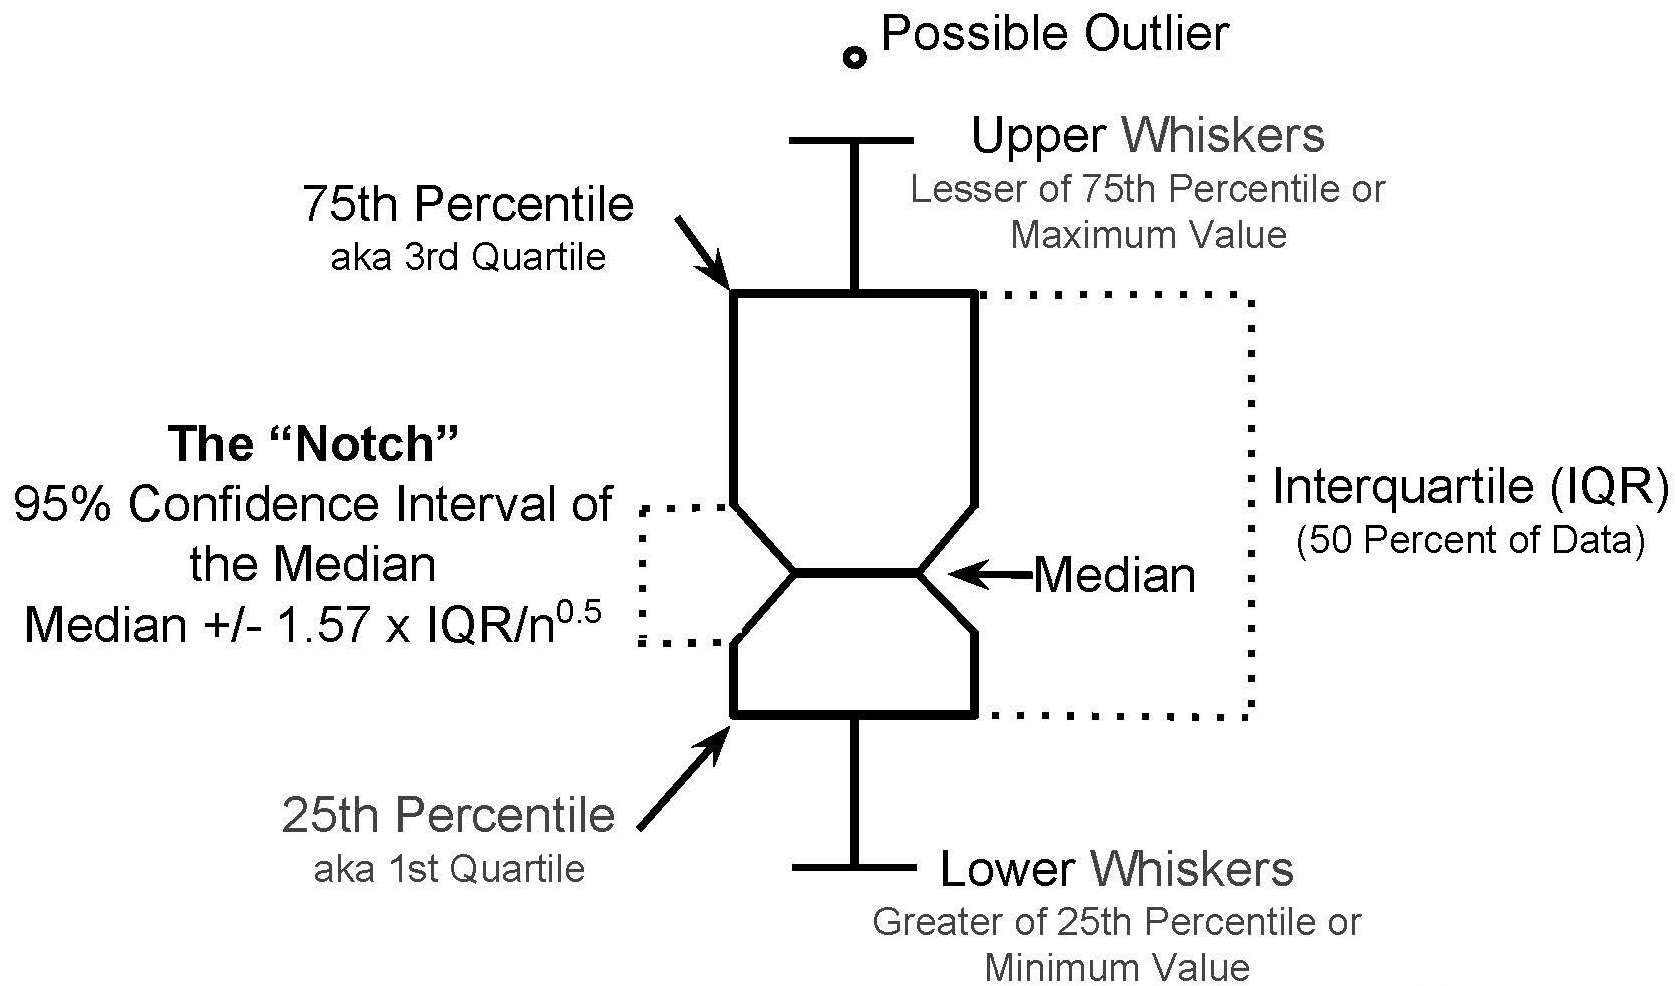

<!-- notched_boxplot_explained_mean.jpg -->
<!-- https://duckduckgo.com/?q=boxplot+with+mean+marker&t=ffab&atb=v343-1&iar=images&iax=images&ia=images&iai=https%3A%2F%2Fwww.researchgate.net%2Fprofile%2FNabin_Basnet3%2Fpublication%2F321962400%2Ffigure%2Ffig4%2FAS%3A573832927944704%401513823839218%2FDiagram-of-boxplot-components-including-mean-median-1st-and-3rd-quartiles-outliers-and.png -->
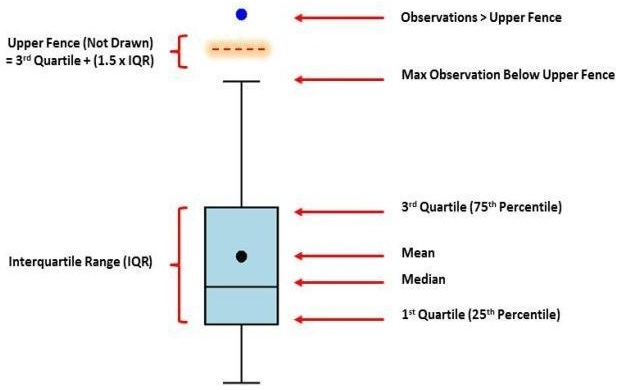

<!-- notched_boxplot_explained_interpretation.jpg -->
<!-- https://sites.google.com/site/davidsstatistics/davids-statistics/notched-box-plots -->
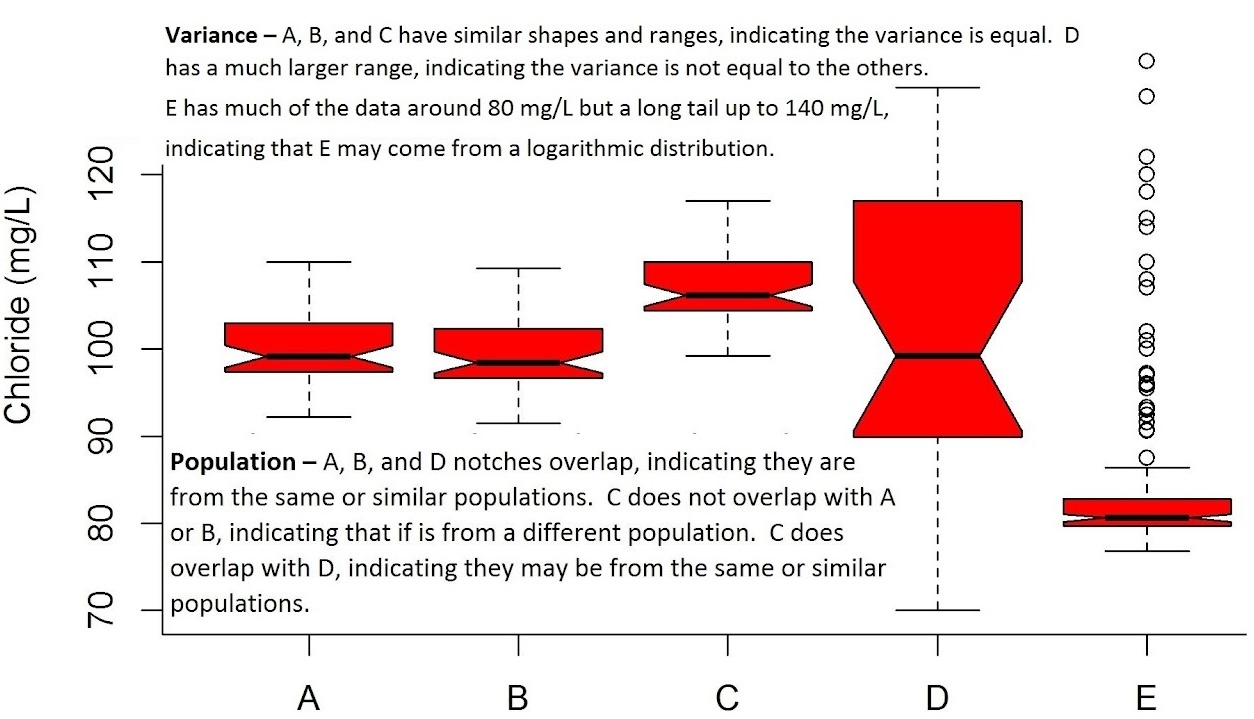
<!-- notched_boxplot_explained_horizontal.jpg -->
<!-- https://www.geeksforgeeks.org/understanding-different-box-plot-with-visualization/ -->
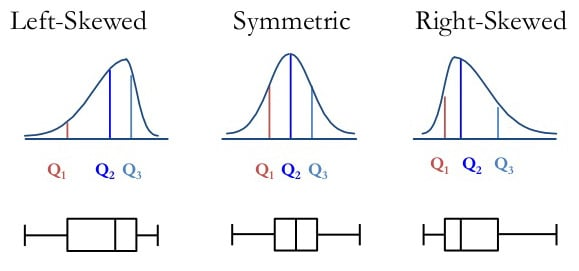
</p>

Create boxplots for 24 features.


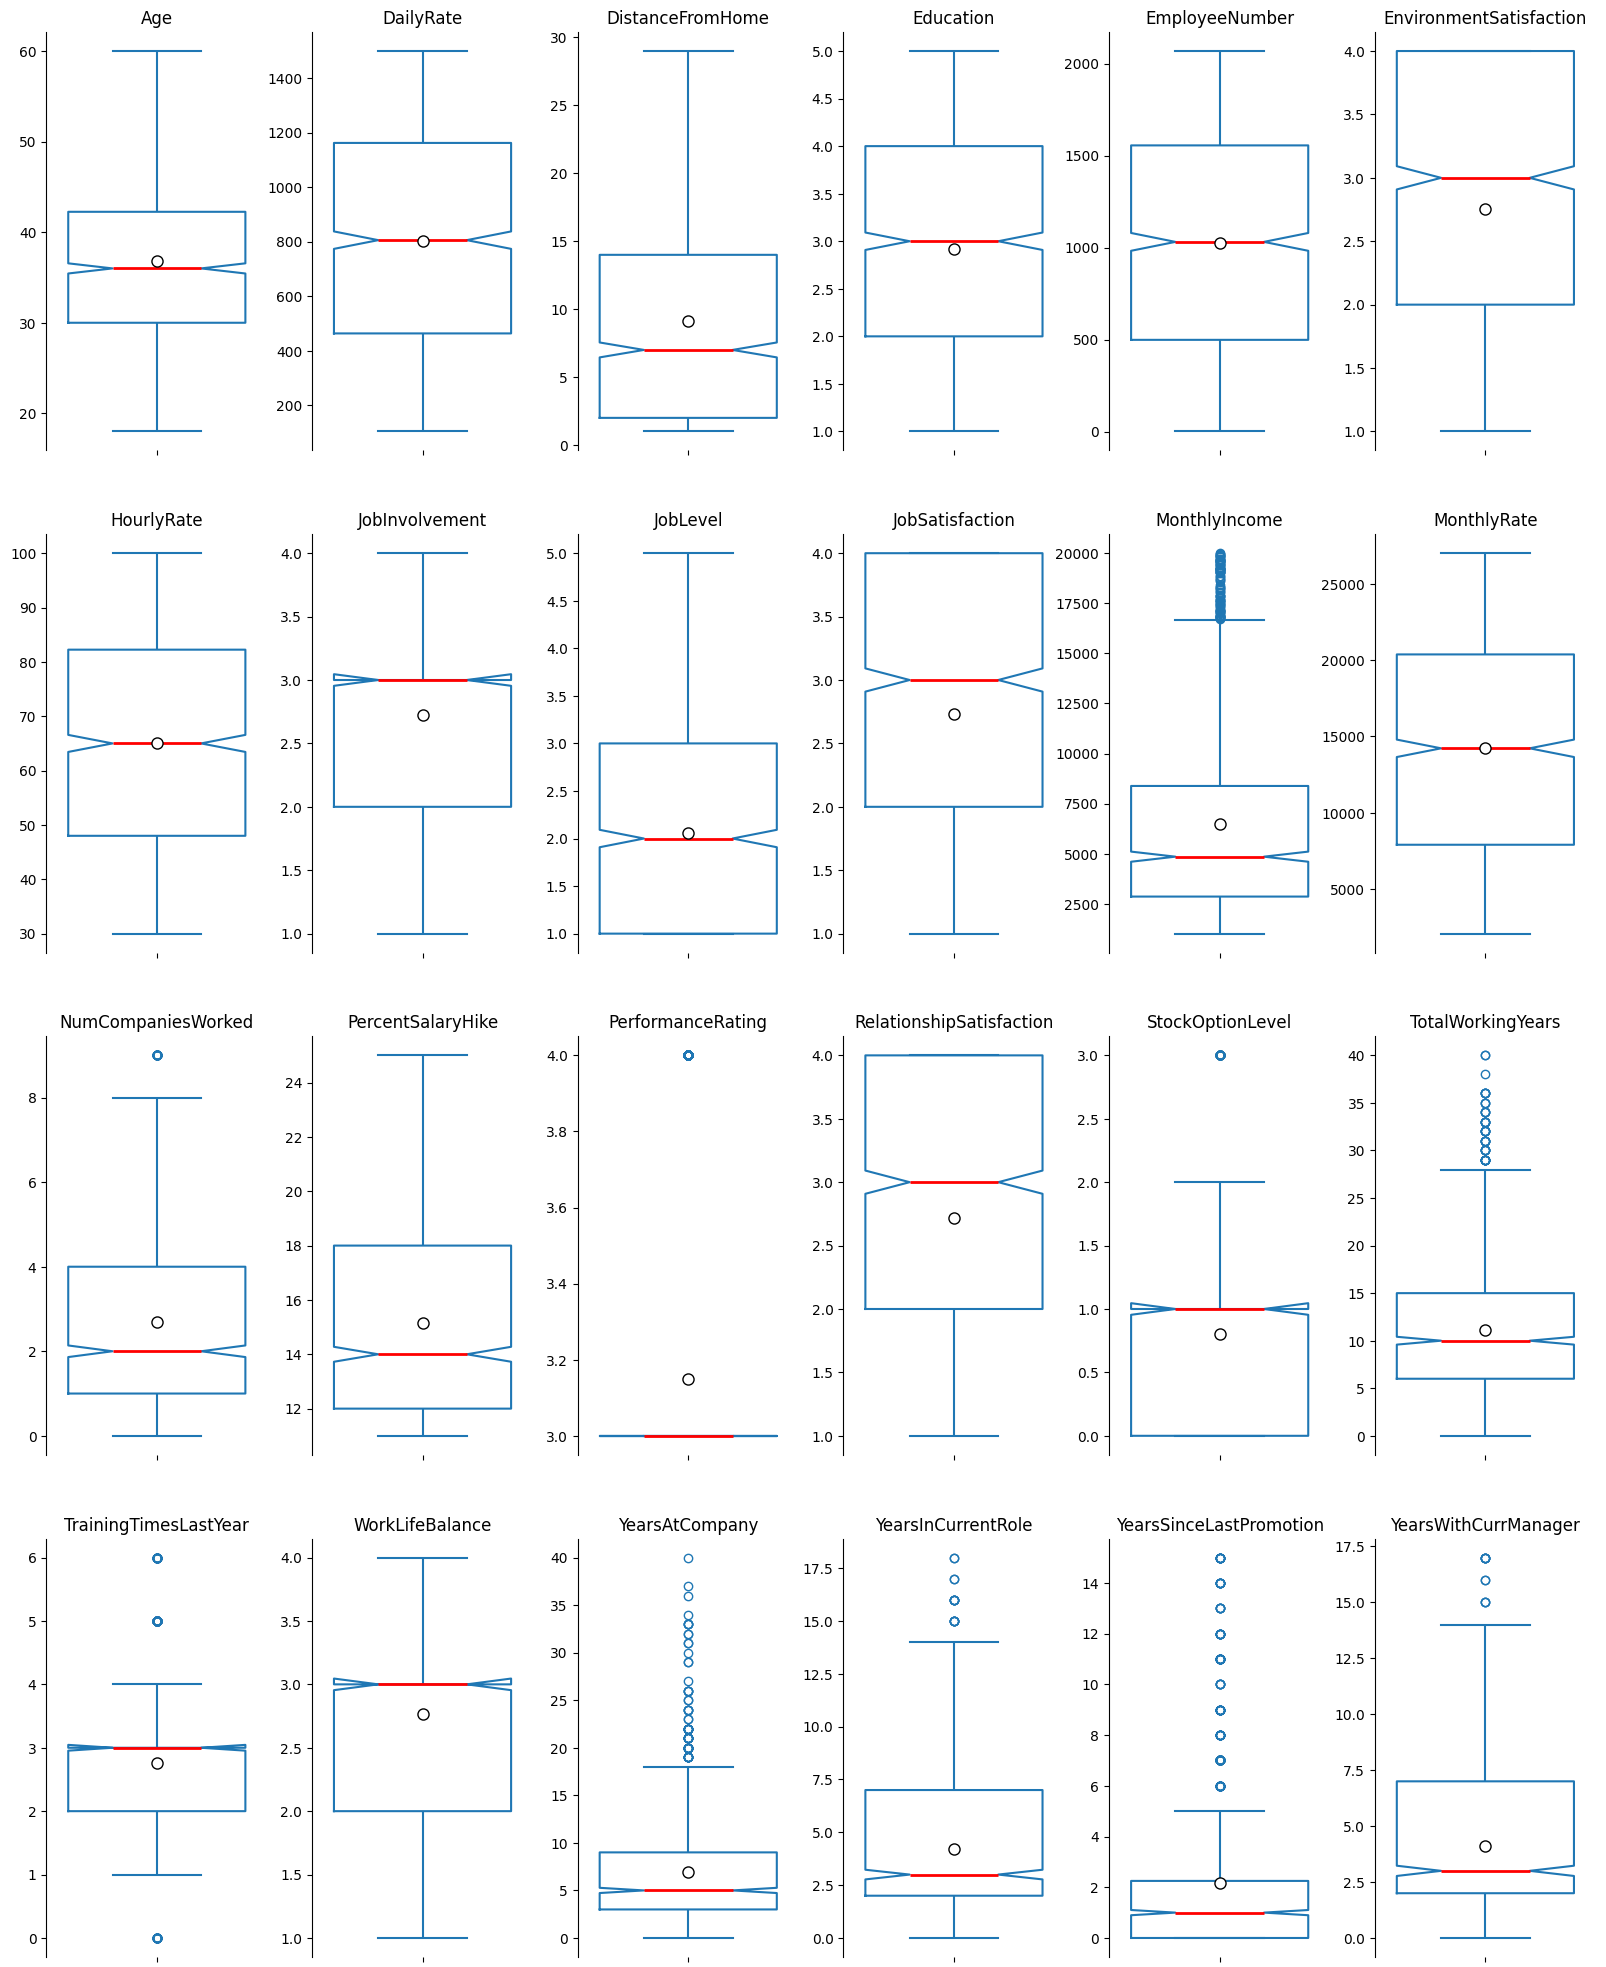

In [12]:
plot_features_boxplots(train_df, numerical_columns_list, single_value_feats_list)

The boxplots above indicate that the features are a blend of features with and without outliers. With the code below we can detect exactly which features are which.

In [13]:
num_feats_list = [x for x in numerical_columns_list if x not in single_value_feats_list]
num_feats_df = train_df[num_feats_list].copy()
iqr_df = num_feats_df.quantile(.75) - num_feats_df.quantile(.25)
lower_whisker_df = num_feats_df.quantile(.25) - 1.5 * iqr_df
upper_whisker_df = num_feats_df.quantile(.75) + 1.5 * iqr_df
outliers_feats_list = num_feats_df.loc[:, ((num_feats_df < lower_whisker_df) | (num_feats_df > upper_whisker_df)).any()].columns.to_list()
non_outliers_feats_list = [x for x in num_feats_list if x not in outliers_feats_list]
print('Features with outliers\n', outliers_feats_list)
print('\nFeatures without outliers\n', non_outliers_feats_list)

Features with outliers
 ['MonthlyIncome', 'NumCompaniesWorked', 'PerformanceRating', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']

Features without outliers
 ['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EmployeeNumber', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyRate', 'PercentSalaryHike', 'RelationshipSatisfaction', 'WorkLifeBalance']


For each category of features we can apply an appropriate scaling. Here though, for all features we wil apply a standard scaler as described above making all features to have zero mean and unit standard deviation. This will serve as our base model. The alternatives are either to follow a mixed strategy where we apply a separate scaler for each feature category or to apply a robust scaler to all features.

We intend to use decision trees and random forests as candidate models among others for which scaling is not needed. Hence, we will keep the scaled features separated till modeling.

**Note:** We are not dropping any outliers as part of our base model.

In [14]:
scaler = StandardScaler()
scaler.fit(num_feats_df)
num_feats_df[num_feats_list] = scaler.transform(num_feats_df)
num_feats_df.head()

,Age,DailyRate,DistanceFromHome,Education,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
1374,2.339,-0.486,1.456,0.081,1.532,1.140,0.339,0.385,1.759,1.150,2.417,-0.349,0.515,-0.589,-0.421,0.265,0.225,2.303,-0.613,-1.072,-0.982,-1.157,-0.674,-1.150
1092,0.904,0.365,2.316,0.081,0.873,1.140,1.571,0.385,-0.955,1.150,-0.916,-1.355,0.515,1.328,2.376,1.190,0.225,-0.408,0.186,0.330,-0.325,-0.055,-0.674,-0.308
768,0.353,-1.237,2.070,0.081,0.066,0.227,0.437,0.385,-0.050,-1.573,0.410,1.118,-0.676,-0.316,-0.421,-0.661,0.225,-0.408,0.186,-1.072,0.003,0.772,1.509,0.253
569,-0.089,1.557,-0.143,1.072,-0.400,-1.598,0.536,-1.014,0.855,-1.573,0.239,-0.003,-0.676,-0.042,-0.421,-0.661,-0.931,-0.150,-1.413,0.330,0.495,0.772,-0.674,1.376
911,-1.303,-0.500,1.825,-1.901,0.414,0.227,0.388,-2.413,-0.955,1.150,-1.131,-0.870,-0.676,-0.316,-0.421,1.190,-0.931,-1.312,0.986,0.330,-0.982,-1.157,-0.362,-1.150


For a sample of features, we can see below how they have been centered around zero.

Create boxplots for 5 features.


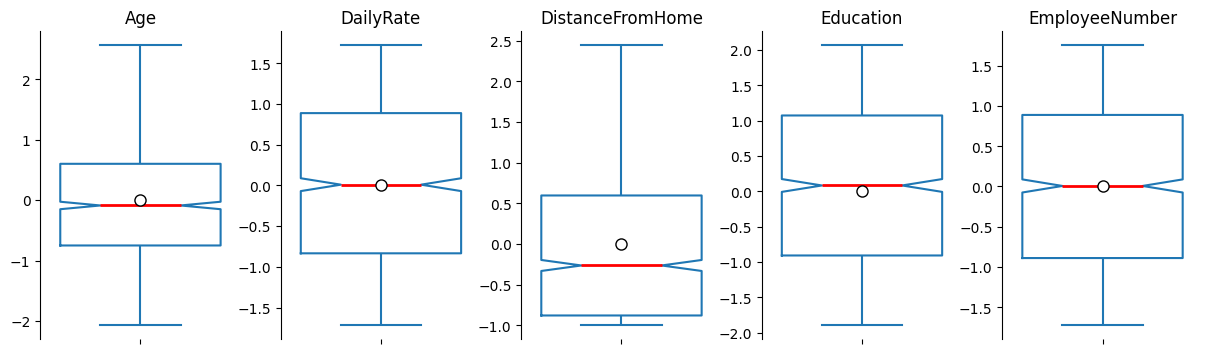

In [15]:
plot_features_boxplots(num_feats_df, ['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EmployeeNumber'], cols=5, figsize=(15, 4))

### Categorical Features

There exist 9 of those with textual values and thus we need to convert them into numbers.

#### Two Value Features

These features come with only two options e.g. "Yes" or "No", "Male" or "Female". We can employ binary encoding i.e., convert "Yes" to 1 and "No" to 0. Similarly, "Male" is mapped to 1 and "Female" to 0.

#### Multi Value Features

These attributes are *'BusinessTravel', 'Department', 'EducationField', 'JobRole'* and *'MaritalStatus'*. We cannot really say how they affect someone to stay or leave the company. There exist arguments for and against for each option. At the same time, the hypothesis is that these features somehow *indeed* affect a person to stay or leave (attrition). Therefore, we will use target-based encoding such as M-estimate and [weight of evidence (WOE)](https://www.listendata.com/2015/03/weight-of-evidence-woe-and-information.html) encoding.

##### Weight of Evidence (WOE)

WOE is a natural choice for this problem because it is a binary classification one. Essentially, WOE is the log-odds within each category i.e., the logarithmic ratio of positive cases over the negative ones. It is also robust to imbalanced data through regularization. It allows to calculate the [information value (IV)](https://www.listendata.com/2015/03/weight-of-evidence-woe-and-information.html) for each categorical feature. Roughly, IV is a weighted sum of the WOE scores of the categories within a categorical feature enabling to evaluate the predictive power of the feature itself. Put differently, through WOE and IV we can perform a cost-effective preliminary feature selection. Based on the WOE and IV scores for each category of a categorical feature it is possible to tell which category is important to predict the target. This can further simplify and enchance a feature by either combining or dropping categories.

In [16]:
# encode categorical variables
binary_cat_cols_list = [col for col in categorical_columns_list if len(train_df[col].unique()) == 2]
multi_cat_cols_list = [col for col in categorical_columns_list if len(train_df[col].unique()) > 2]
# binary ones
print('* Binary features')
for feat in binary_cat_cols_list:
    enc = LabelEncoder()
    enc.fit(train_df[feat])
    print('->', '{0: <15}'.format(feat), 'classes:', '{0: <20}'.format(str(enc.classes_)), 'encoded as:', enc.transform(enc.classes_))
    train_df[feat] = enc.transform(train_df[feat])

# multi value ones
print('\n* Multi valued features')
target = 'Attrition'
contigency_tables_df = woe_encode_cat_feats_with_contigency_table(train_df, target, multi_cat_cols_list, verbose=True)

print('\n\nSample encoded data')
train_df.head()

* Binary features
-> Attrition       classes: ['No' 'Yes']         encoded as: [0 1]
-> Gender          classes: ['Female' 'Male']    encoded as: [0 1]
-> OverTime        classes: ['No' 'Yes']         encoded as: [0 1]

* Multi valued features
-> BusinessTravel  Information Value: 0.141 
classes: ['Travel_Rarely', 'Non-Travel', 'Travel_Frequently'] encoded as: ['-0.091', '-0.817', '0.588']
-> Department      Information Value: 0.059 
classes: ['Sales', 'Research & Development', 'Human Resources'] encoded as: ['0.306', '-0.190', '0.374']
-> EducationField  Information Value: 0.116 
classes: ['Life Sciences', 'Technical Degree', 'Marketing', 'Medical', 'Human Resources', 'Other'] encoded as: ['-0.163', '0.588', '0.488', '-0.265', '0.897', '0.117']
-> JobRole         Information Value: 0.514 
classes: ['Manager', 'Research Scientist', 'Sales Executive', 'Sales Representative', 'Laboratory Technician', 'Manufacturing Director', 'Human Resources', 'Research Director', 'Healthcare Representa

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
1374,58,-0.091,605,0.306,21,3,-0.163,1938,4,0,72,3,4,-1.097,4,-0.308,17875,11761,4,1,13,3,3,1,29,2,2,1,0,0,0,0
1092,45,-0.091,950,-0.190,28,3,0.588,1546,4,1,97,3,1,-0.061,4,-0.308,2132,4585,4,0,20,4,4,1,8,3,3,5,4,0,3,0
768,40,-0.091,300,0.306,26,3,0.488,1066,3,1,74,3,2,0.060,1,-0.308,8396,22217,1,0,14,3,2,1,8,3,2,7,7,7,5,0
569,36,-0.817,1434,0.306,8,4,-0.163,789,1,1,76,2,3,0.060,1,0.552,7587,14229,1,0,15,3,2,0,10,1,3,10,7,0,9,0
911,25,0.588,599,0.306,24,1,-0.163,1273,3,1,73,1,1,1.354,4,0.552,1118,8040,1,1,14,3,4,0,1,4,3,1,0,1,0,1


In [17]:
train_df.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Index: 1176 entries, 1374 to 684
Columns: 32 entries, Age to Attrition
dtypes: float64(5), int64(27)
memory usage: 303.2 KB


In [18]:
train_df

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
1374,58,-0.091,605,0.306,21,3,-0.163,1938,4,0,72,3,4,-1.097,4,-0.308,17875,11761,4,1,13,3,3,1,29,2,2,1,0,0,0,0
1092,45,-0.091,950,-0.190,28,3,0.588,1546,4,1,97,3,1,-0.061,4,-0.308,2132,4585,4,0,20,4,4,1,8,3,3,5,4,0,3,0
768,40,-0.091,300,0.306,26,3,0.488,1066,3,1,74,3,2,0.060,1,-0.308,8396,22217,1,0,14,3,2,1,8,3,2,7,7,7,5,0
569,36,-0.817,1434,0.306,8,4,-0.163,789,1,1,76,2,3,0.060,1,0.552,7587,14229,1,0,15,3,2,0,10,1,3,10,7,0,9,0
911,25,0.588,599,0.306,24,1,-0.163,1273,3,1,73,1,1,1.354,4,0.552,1118,8040,1,1,14,3,4,0,1,4,3,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,34,-0.091,1333,0.306,10,4,-0.163,1055,3,0,87,3,1,1.354,3,-0.308,2220,18410,1,1,19,3,4,1,1,2,3,1,1,0,0,0
835,35,-0.091,528,0.374,8,4,0.588,1164,3,1,100,3,1,0.639,3,0.552,4323,7108,1,0,17,3,2,0,6,2,1,5,4,1,4,0
1216,43,-0.091,1179,0.306,2,3,-0.265,1706,4,1,73,3,2,0.060,4,-0.308,7847,6069,1,1,17,3,1,1,10,3,3,10,9,8,8,0
559,38,-0.091,268,-0.190,2,5,-0.265,773,4,1,92,3,1,-0.061,3,-0.308,3057,20471,6,1,13,3,2,1,6,0,1,1,0,0,1,0


All textual data have been encoded as we see above; all data types are either floats or integers.

Moreover, according to [this table](https://www.listendata.com/2015/03/weight-of-evidence-woe-and-information.html) 
about IV values significance, *'Department'* and *'EducationField'* are weak predictors,  *'BusinessTravel'* has weak to moderate predictive power. *'MaritalStatus'* has medium predictive power and lastly *'JobRole'* has the most power and it is a strong predictor. Notice all 5 features have a mixed effect to attrition. For instance, for singles the WOE score is positive but for married and divorced the scores are negative. In other words, singles are more prone to leave while married and divorced are more keen to stay.

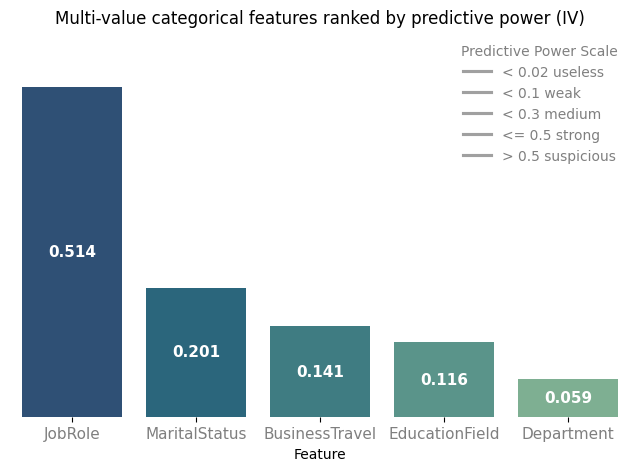

In [19]:
plot_cat_feats_by_iv_ranking(contigency_tables_df)

*'JobRole'* is the most strong predictor for attrition. *'MaritalStatus'* comes second as a moderate predictor. The other features based on IV are not important and thus we could drop them. For this analysis, instead of dropping them, we will create two family of models, one including them and one excluding and we will see what happens.

Below are some more plots exploring the predictive power of *'JobRole'* and *'MaritalStatus'*.

In [20]:
feat = 'JobRole'
feat_df = contigency_tables_df[contigency_tables_df['Feature'] == feat].copy()
feat_df['Not Leave %'] = feat_df['Negative'] / feat_df['Total']
feat_df

,Feature,Category,Positive,Negative,Total,Prob(Category|Target=1),Prob(Category|Target=0),WOE,IV,Not Leave %
12,JobRole,Research Director,1,62,63,0.005,0.063,-1.799,0.103,0.984
13,JobRole,Manufacturing Director,6,111,117,0.032,0.112,-1.122,0.090,0.949
14,JobRole,Manager,4,77,81,0.021,0.078,-1.097,0.062,0.951
15,JobRole,Healthcare Representative,8,90,98,0.043,0.091,-0.663,0.032,0.918
16,JobRole,Research Scientist,36,204,240,0.191,0.206,-0.061,0.001,0.850
17,JobRole,Sales Executive,43,215,258,0.229,0.218,0.060,0.001,0.833
18,JobRole,Laboratory Technician,51,159,210,0.271,0.161,0.527,0.058,0.757
19,JobRole,Human Resources,11,32,43,0.059,0.032,0.639,0.017,0.744
20,JobRole,Sales Representative,28,38,66,0.149,0.038,1.354,0.150,0.576


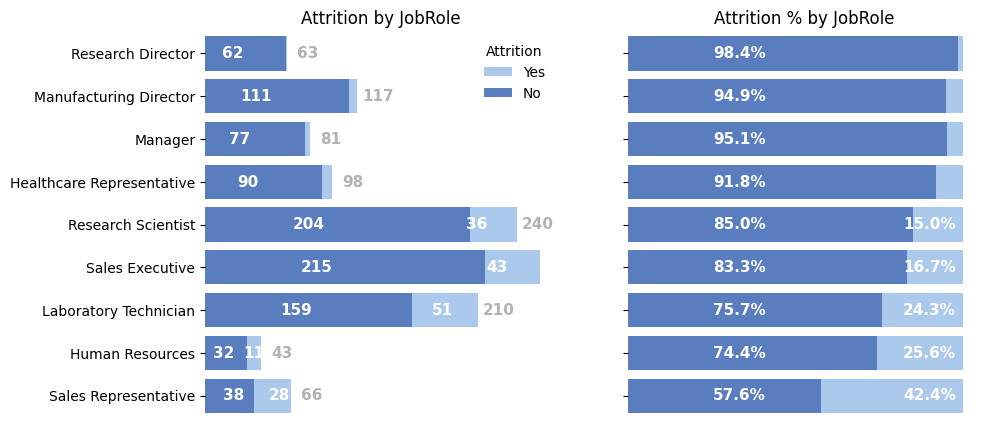

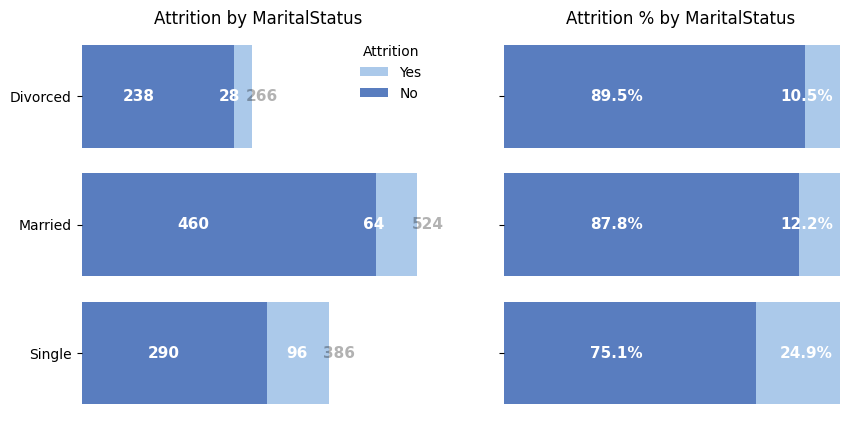

In [21]:
target = 'Attrition'
significant_cat_feats_list = ['JobRole', 'MaritalStatus']
for feat in significant_cat_feats_list:
    plot_target_by_cat_feat(target, feat, contigency_tables_df)

For **'JobRole'** we observe there are 3 main groups. The first group includes *'Research Director', 'Manager', 'Manufacturing Director'* and *'Healthcare Representative'*. In this group the attrition is very low i.e., the employees of these job roles don't leave the company. The second group is made of *'Research Scientist'* and *'Sales Executive'*. In this group, the relative attrition is about 16% - 17%. The last and third group is comprised by *'Human Resources', 'Laboratory Technician'* and *'Sales Representative'*. This group has high relative attrition from almost 25% up to almost 40%. This group has more variability compared to the other two.

For **'MaritalStatus'** we notice two groups, one including the married and divorced with an attrition of about 10% and another one is the singles themselves with almost 26% attrition. The former group encompasses employees staying at the company whereas the latter group is more volatile. Intuitively, this is expected as married and divorced people may be more settled and in favor of a more stable life while singles are more open to risk.

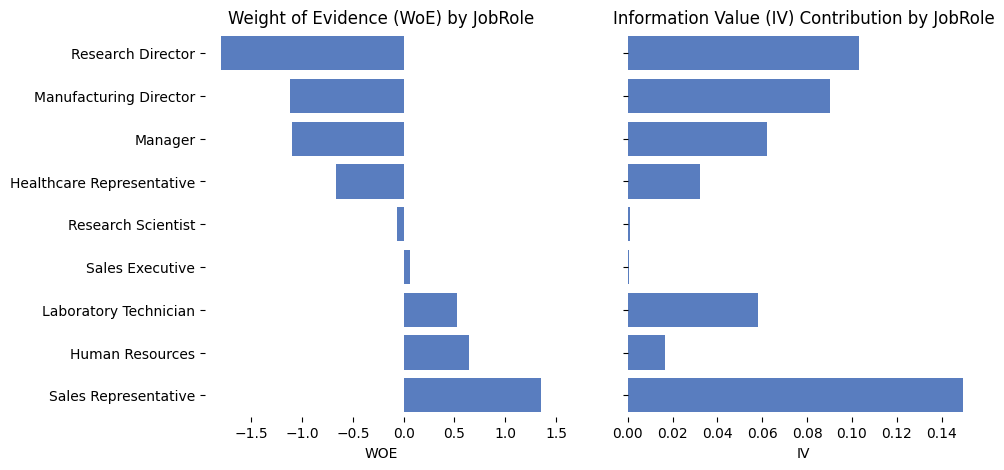

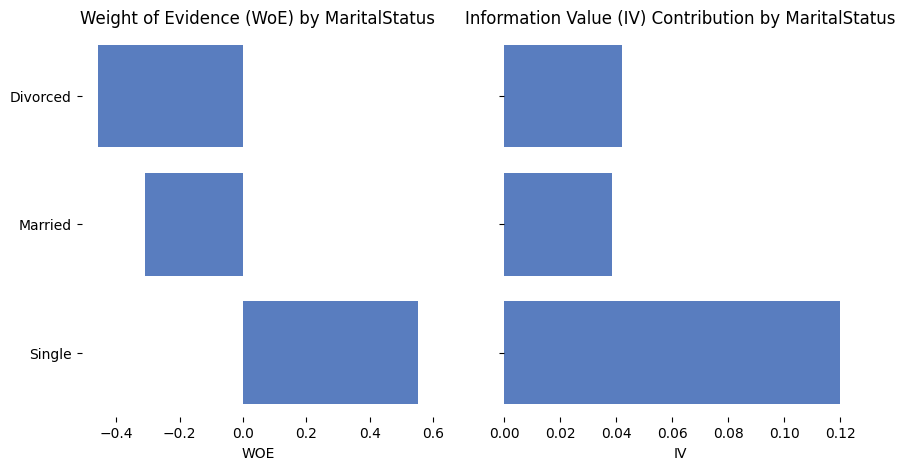

In [22]:
for feat in significant_cat_feats_list:
    plot_cat_feat_woe_iv(feat, contigency_tables_df)

The graphs above confirm the grouping suggested earlier for both *'JobRole'* and *'MaritalStatus'*.

Specifically, for *'JobRole'* the first group is a strong indicator for someone staying in the company (negative WOE scores) while the third group is a strong indicator for an employee leaving the company (positive WOE scores). The second group appears neutral, neither negative nor positive, and thus we could eliminate it completely or combine it with the other two groups. For instance, *'Research Scientist'*s could be combined with *'Healthcare Representative'*s and *'Sales Executive'* could be united with *'Human Resources'*. For now, we will leave them as is. In terms of informatiion value, *'Human Resources'* could be merged with *'Laboratory Technician'*s.

For *'MaritalStatus'* we notice the singles to be strongly associated with attrition and the rest to be strongly associated with remaining at the company. Interestingly, the divorced ones appear more willing to stay than the married ones.

The following corrreslation visualization shows that the categorical features overall are independent of each other with the exception of *'JobRole'* and *'Department'*.

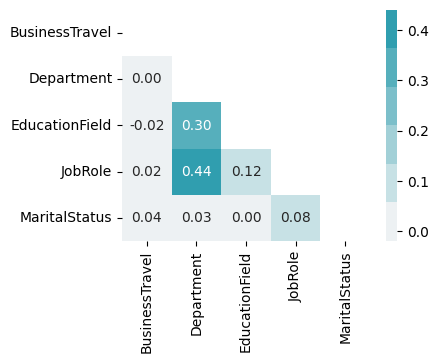

In [23]:
plot_numerical_correlation_heatmap(train_df, multi_cat_cols_list, method='spearman', figsize=(4, 3))

We can run a [$\chi^2$ test of independence](https://www.statology.org/when-to-use-chi-square-test/) on *'JobRole'* and *'Department'* to examine further their association. This test [assumes](https://medium.com/@manindersingh120996/understanding-categorical-correlations-with-chi-square-test-and-cramers-v-a54fe153b1d6)
- Two categorical variables
- Relatively large sample size
- Categories of variables (two or more)
- Independence of observations

The $\chi^2$ test of independence uses the following null and alternative hypotheses:
- $H_0$: (null hypothesis) The two variables are independent.
- $H_1$: (alternative hypothesis) The two variables are not independent.

In case we reject the null hypothesis assuming a significance level $\alpha = 0.05$ and the featues are not independent, we can calculate [Cramer's V](https://www.statology.org/interpret-cramers-v/) to measure the strength of the association between the two. Its range is [0-1] where
- 0 means no association and,
- 1 means a perfect association.

Cramer's V may need a [bias correction](https://medium.com/@manindersingh120996/understanding-categorical-correlations-with-chi-square-test-and-cramers-v-a54fe153b1d6) when is calculated on the entire population. Thus the calculated correlation may overstate the actual strength of the association between variables. Here, we use 80% of the data.

In [24]:
contigency_df = pd.crosstab(train_df['Department'], train_df['JobRole'], margins=True) 
contigency_df

JobRole,-1.799,-1.122,-1.097,-0.663,-0.061,0.060,0.527,0.639,1.354,All
Department,,,,,,,,,,
-0.190,63,117,44,98,240,0,210,0,0,772
0.306,0,0,27,0,0,258,0,0,66,351
0.374,0,0,10,0,0,0,0,43,0,53
All,63,117,81,98,240,258,210,43,66,1176


In [25]:
stat, p, dof, expected = chi2_contingency(contigency_df)
n = contigency_df['All'].max()
r, k = contigency_df.shape
phi2 = stat/n
cramers_v = np.sqrt(phi2 / min([r - 1, k - 1]))
# correction for bias
phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
rcorr = r - ((r - 1) ** 2) / ( n - 1 )
kcorr = k - ((k - 1) ** 2) / ( n - 1 )
cramers_v_cor = np.sqrt(phi2corr / min([rcorr, kcorr]))

float(p), float(stat), dof, float(cramers_v), float(cramers_v_cor)

(0.0, 2066.582174193866, 27, 0.7653534623888179, 0.6590990919176567)

Here the p-value is 0 and thus we reject the null hypothesis that *'JobRole'* and *'Department'* are independent.
With a value of **0.66** (corrected) and **27** degrees of freedom we can tell that the association is very strong.

## 2.2 Feature Relationships

Here, we will examine data correlations and multicolinearity among features.

Given that the dataset is a blend of categorical, discrete and continuous features, we will examine their relationships into groups.

### Numerical Features

[Pearson](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient), [Spearman](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient) and [Kendall’s Tau ](https://en.wikipedia.org/wiki/Kendall_rank_correlation_coefficient) correlation coefficients are three common options here. All methods calculate a correlation coefficient ranging in the interval $[−1, 1]$ where
- 1 &rarr; perfect positive correlation
- 0 &rarr; no correlation
- −1 &rarr; perfect negative correlation

These methods however are not equivalent. They measure quite different things:
- Pearson (r): measures the **linear** relationship between two continuous variables.
- Spearman (ρ or rs) and Kendall’s Tau: measure the **monotonic** relationship (not necessarily linear) between two variables.

Also they have their own assumptions. In the context of descriptive analysis, the main difference is that Pearson's assumes linear relationships among variables while Spearman and Kendall assume the relationship to be monotonic, either increasing or decreasing.

Pearson's coefficient is sensitive to outliers since through the sample mean, standard deviation and covariance depends on the raw sample values. Spearman's coefficient is more robust as it depends on ranks and not the values directly. Kendall’s Tau is the most robust in outliers as it quantifies the amount of pairwise that increase or decrease.

Lastly, since we have converted the categorical features to numerical ones through Weight of Evidence encoding, we can add them to the correlation analysis as well. We are going only to add *'JobRole'* and *'MaritalStatus'* as they provide the most predictive power.

In [26]:
threshold = .6
all_feats_list = num_feats_list + significant_cat_feats_list
train_df[all_feats_list].corr(method='pearson')

,Age,DailyRate,DistanceFromHome,Education,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,JobRole,MaritalStatus
Age,1.000,0.017,-0.006,0.201,0.010,0.016,0.036,0.044,0.522,0.004,0.512,0.009,0.322,0.020,0.001,0.060,0.046,0.687,-0.015,-0.019,0.318,0.220,0.214,0.204,-0.384,-0.140
DailyRate,0.017,1.000,-0.013,-0.013,-0.041,0.013,0.025,0.045,0.004,0.042,0.010,-0.019,0.020,0.021,-0.009,0.000,0.045,0.022,0.000,-0.017,-0.022,0.027,-0.016,-0.002,-0.010,-0.072
DistanceFromHome,-0.006,-0.013,1.000,-0.005,0.029,-0.013,0.025,0.020,0.007,0.003,-0.018,0.010,-0.044,0.024,0.020,0.029,0.057,-0.005,-0.052,-0.011,-0.004,0.015,-0.006,0.014,0.020,-0.046
Education,0.201,-0.013,-0.005,1.000,0.058,-0.038,0.004,0.053,0.107,-0.003,0.103,-0.040,0.128,-0.025,-0.044,0.000,0.017,0.148,-0.016,0.026,0.070,0.064,0.044,0.063,-0.112,-0.006
EmployeeNumber,0.010,-0.041,0.029,0.058,1.000,0.042,0.015,-0.012,-0.010,-0.047,-0.005,0.009,0.020,-0.010,-0.021,-0.064,0.041,-0.009,-0.019,0.006,-0.019,-0.019,-0.016,-0.025,0.020,-0.022
EnvironmentSatisfaction,0.016,0.013,-0.013,-0.038,0.042,1.000,-0.048,0.000,0.011,-0.016,0.004,0.030,0.010,-0.017,-0.015,0.019,-0.003,-0.004,-0.014,0.038,-0.004,0.029,0.017,-0.009,-0.002,0.004
HourlyRate,0.036,0.025,0.025,0.004,0.015,-0.048,1.000,0.070,-0.022,-0.065,-0.014,-0.024,0.016,0.008,0.006,0.008,0.039,0.001,-0.023,-0.013,-0.012,-0.011,-0.001,-0.022,0.016,-0.021
JobInvolvement,0.044,0.045,0.020,0.053,-0.012,0.000,0.070,1.000,0.018,-0.012,0.011,-0.030,0.010,-0.028,-0.047,0.037,0.001,0.024,-0.038,-0.022,0.005,0.019,-0.013,0.036,-0.062,-0.032
JobLevel,0.522,0.004,0.007,0.107,-0.010,0.011,-0.022,0.018,1.000,-0.006,0.949,0.028,0.172,-0.029,-0.021,0.009,0.031,0.785,0.003,0.039,0.527,0.382,0.353,0.368,-0.688,-0.102
JobSatisfaction,0.004,0.042,0.003,-0.003,-0.047,-0.016,-0.065,-0.012,-0.006,1.000,-0.013,-0.005,-0.029,0.046,0.026,-0.023,0.032,-0.022,-0.024,-0.013,-0.030,-0.031,-0.050,-0.049,-0.011,0.014


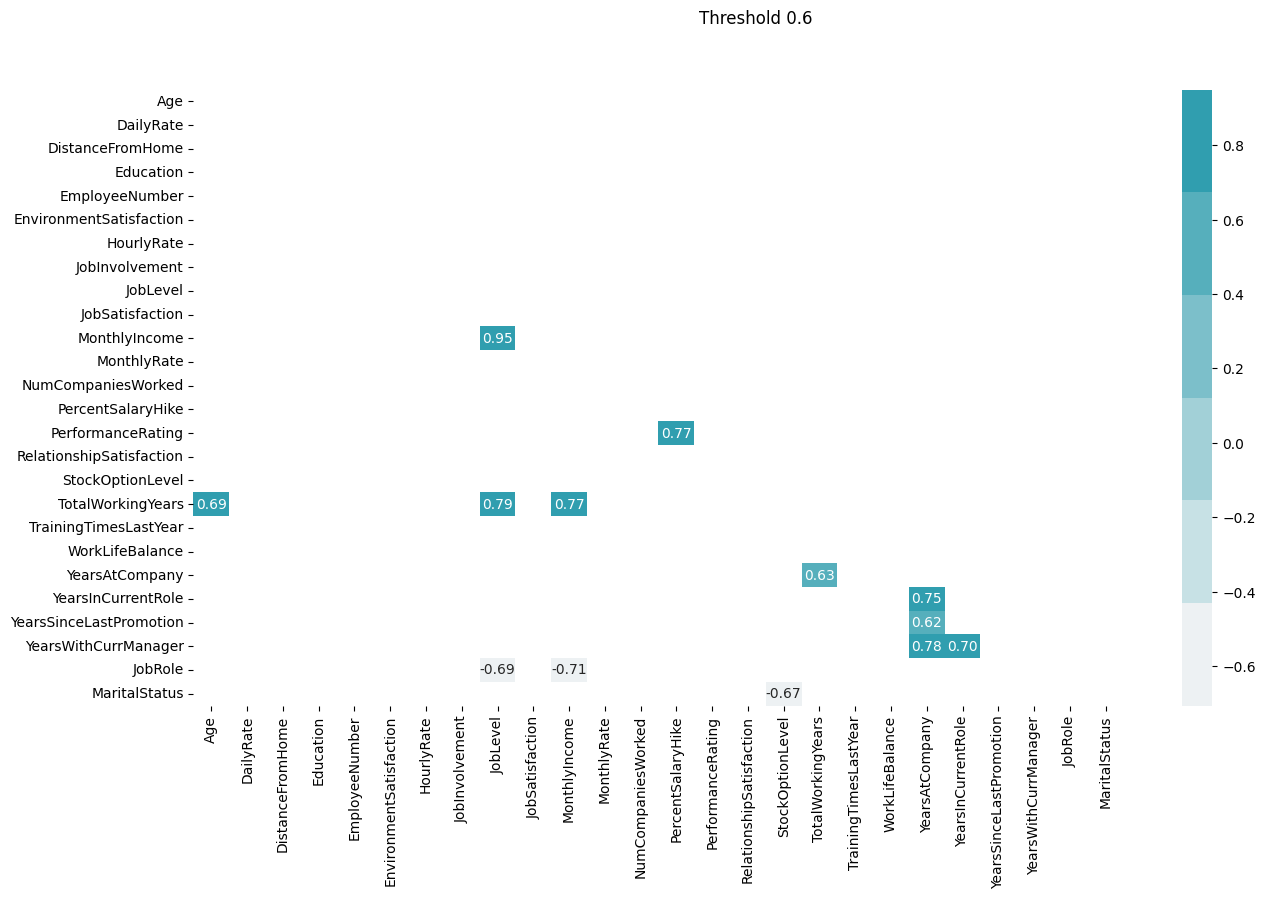

In [27]:
plot_numerical_correlation_heatmap(train_df, all_feats_list, method='pearson', threshold=threshold, figsize=(15, 8))

In [28]:
train_df[all_feats_list].corr(method='spearman')

,Age,DailyRate,DistanceFromHome,Education,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,JobRole,MaritalStatus
Age,1.000,0.013,-0.031,0.193,0.016,0.015,0.041,0.044,0.498,0.002,0.482,0.003,0.382,0.023,-0.004,0.055,0.070,0.659,-0.004,0.006,0.258,0.201,0.158,0.199,-0.321,-0.108
DailyRate,0.013,1.000,-0.013,-0.012,-0.041,0.014,0.024,0.041,0.007,0.037,0.022,-0.021,0.022,0.018,-0.008,0.003,0.039,0.032,-0.015,-0.022,0.007,0.027,-0.031,0.017,-0.014,-0.062
DistanceFromHome,-0.031,-0.013,1.000,-0.009,0.039,-0.007,0.024,0.043,0.021,-0.005,-0.004,0.019,-0.022,0.017,0.001,0.029,0.046,-0.007,-0.035,-0.005,0.013,0.018,-0.002,0.009,0.037,-0.045
Education,0.193,-0.012,-0.009,1.000,0.060,-0.044,0.003,0.044,0.110,0.004,0.131,-0.031,0.137,-0.005,-0.038,-0.006,0.010,0.162,-0.021,0.036,0.062,0.055,0.014,0.045,-0.101,0.012
EmployeeNumber,0.016,-0.041,0.039,0.060,1.000,0.046,0.016,-0.008,-0.002,-0.047,0.017,0.009,0.029,-0.005,-0.021,-0.066,0.044,-0.002,-0.007,0.006,0.005,-0.007,0.012,-0.019,0.024,0.005
EnvironmentSatisfaction,0.015,0.014,-0.007,-0.044,0.046,1.000,-0.049,-0.007,0.009,-0.013,-0.012,0.030,0.008,-0.018,-0.015,0.018,0.005,-0.016,-0.009,0.037,0.004,0.024,0.034,-0.003,-0.015,0.003
HourlyRate,0.041,0.024,0.024,0.003,0.016,-0.049,1.000,0.069,-0.027,-0.062,-0.019,-0.023,0.014,0.010,0.006,0.009,0.045,-0.008,-0.008,-0.018,-0.021,-0.021,-0.045,-0.018,0.009,-0.016
JobInvolvement,0.044,0.041,0.043,0.044,-0.008,-0.007,0.069,1.000,0.006,-0.000,-0.008,-0.031,0.008,-0.024,-0.040,0.041,0.013,0.025,-0.015,-0.027,0.034,0.026,-0.003,0.047,-0.057,-0.033
JobLevel,0.498,0.007,0.021,0.110,-0.002,0.009,-0.027,0.006,1.000,-0.004,0.919,0.037,0.205,-0.027,-0.019,0.001,0.060,0.741,-0.005,0.047,0.478,0.394,0.266,0.375,-0.554,-0.092
JobSatisfaction,0.002,0.037,-0.005,0.004,-0.047,-0.013,-0.062,-0.000,-0.004,1.000,0.002,-0.011,-0.027,0.045,0.031,-0.023,0.032,-0.017,-0.030,-0.019,-0.016,-0.024,-0.003,-0.031,-0.026,0.010


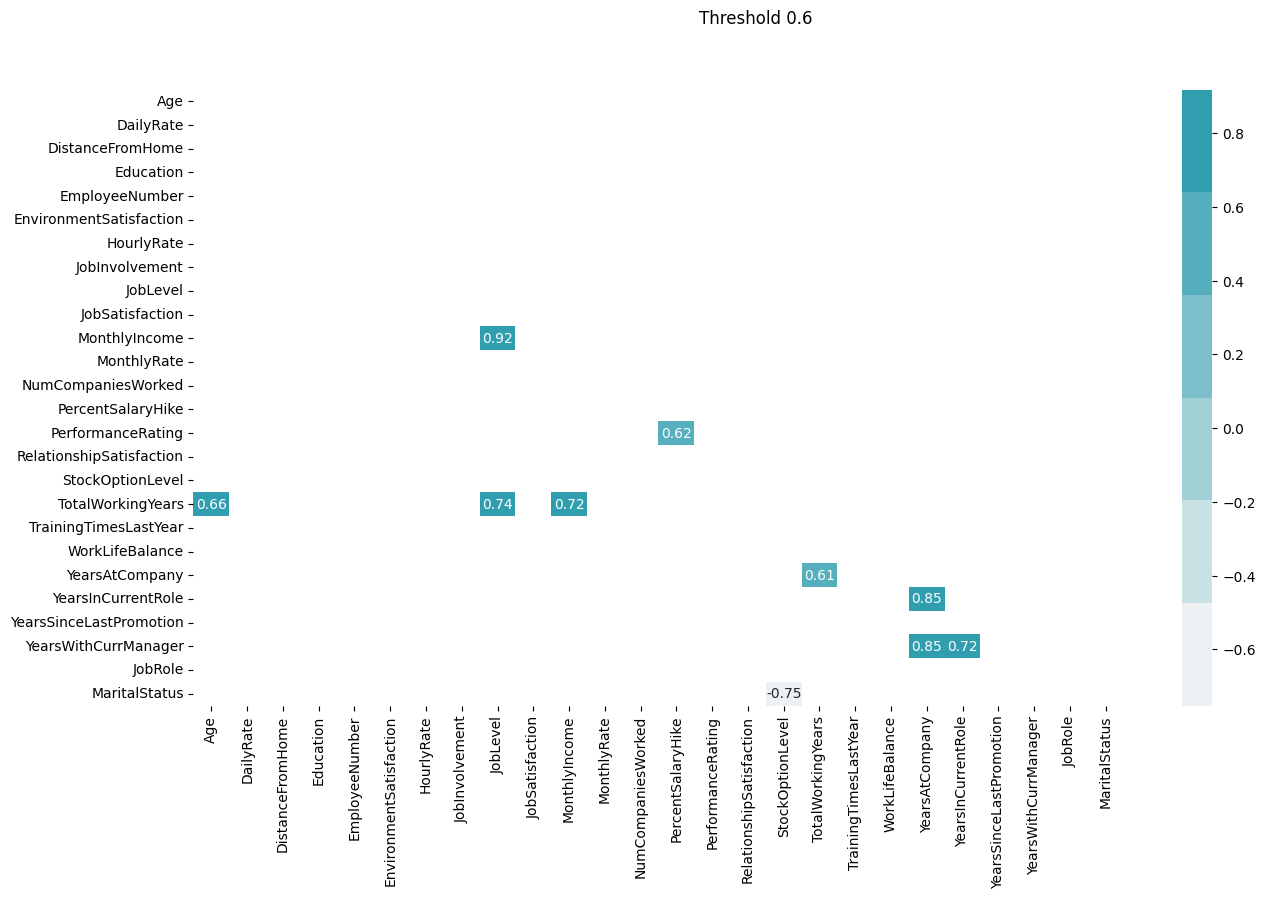

In [29]:
plot_numerical_correlation_heatmap(train_df, all_feats_list, method='spearman', threshold=0.6, figsize=(15, 8))

In [30]:
train_df[all_feats_list].corr(method='kendall')

,Age,DailyRate,DistanceFromHome,Education,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,JobRole,MaritalStatus
Age,1.000,0.009,-0.022,0.148,0.011,0.011,0.028,0.034,0.398,0.002,0.342,0.002,0.276,0.017,-0.004,0.042,0.054,0.505,-0.003,0.005,0.191,0.148,0.118,0.147,-0.235,-0.084
DailyRate,0.009,1.000,-0.009,-0.009,-0.027,0.010,0.017,0.032,0.005,0.028,0.015,-0.014,0.016,0.013,-0.007,0.002,0.030,0.022,-0.011,-0.017,0.005,0.019,-0.023,0.013,-0.010,-0.048
DistanceFromHome,-0.022,-0.009,1.000,-0.007,0.027,-0.005,0.017,0.035,0.017,-0.004,-0.002,0.013,-0.016,0.013,0.001,0.023,0.036,-0.005,-0.026,-0.004,0.010,0.013,-0.002,0.006,0.027,-0.036
Education,0.148,-0.009,-0.007,1.000,0.045,-0.037,0.002,0.038,0.093,0.003,0.098,-0.024,0.111,-0.004,-0.035,-0.005,0.008,0.124,-0.017,0.031,0.048,0.044,0.011,0.035,-0.082,0.010
EmployeeNumber,0.011,-0.027,0.027,0.045,1.000,0.034,0.012,-0.006,-0.001,-0.036,0.011,0.006,0.021,-0.004,-0.017,-0.050,0.034,-0.001,-0.005,0.005,0.002,-0.006,0.008,-0.013,0.017,0.004
EnvironmentSatisfaction,0.011,0.010,-0.005,-0.037,0.034,1.000,-0.037,-0.006,0.008,-0.011,-0.009,0.023,0.006,-0.014,-0.013,0.015,0.004,-0.012,-0.008,0.032,0.003,0.019,0.028,-0.002,-0.012,0.002
HourlyRate,0.028,0.017,0.017,0.002,0.012,-0.037,1.000,0.054,-0.020,-0.047,-0.013,-0.015,0.010,0.007,0.005,0.007,0.035,-0.005,-0.006,-0.014,-0.014,-0.015,-0.033,-0.013,0.006,-0.012
JobInvolvement,0.034,0.032,0.035,0.038,-0.006,-0.006,0.054,1.000,0.005,-0.000,-0.006,-0.024,0.007,-0.019,-0.038,0.036,0.012,0.019,-0.013,-0.024,0.027,0.021,-0.002,0.039,-0.047,-0.030
JobLevel,0.398,0.005,0.017,0.093,-0.001,0.008,-0.020,0.005,1.000,-0.003,0.805,0.027,0.166,-0.021,-0.018,0.001,0.052,0.622,-0.004,0.042,0.391,0.322,0.223,0.308,-0.457,-0.080
JobSatisfaction,0.002,0.028,-0.004,0.003,-0.036,-0.011,-0.047,-0.000,-0.003,1.000,0.002,-0.008,-0.022,0.035,0.028,-0.020,0.028,-0.013,-0.025,-0.017,-0.012,-0.019,-0.002,-0.024,-0.020,0.009


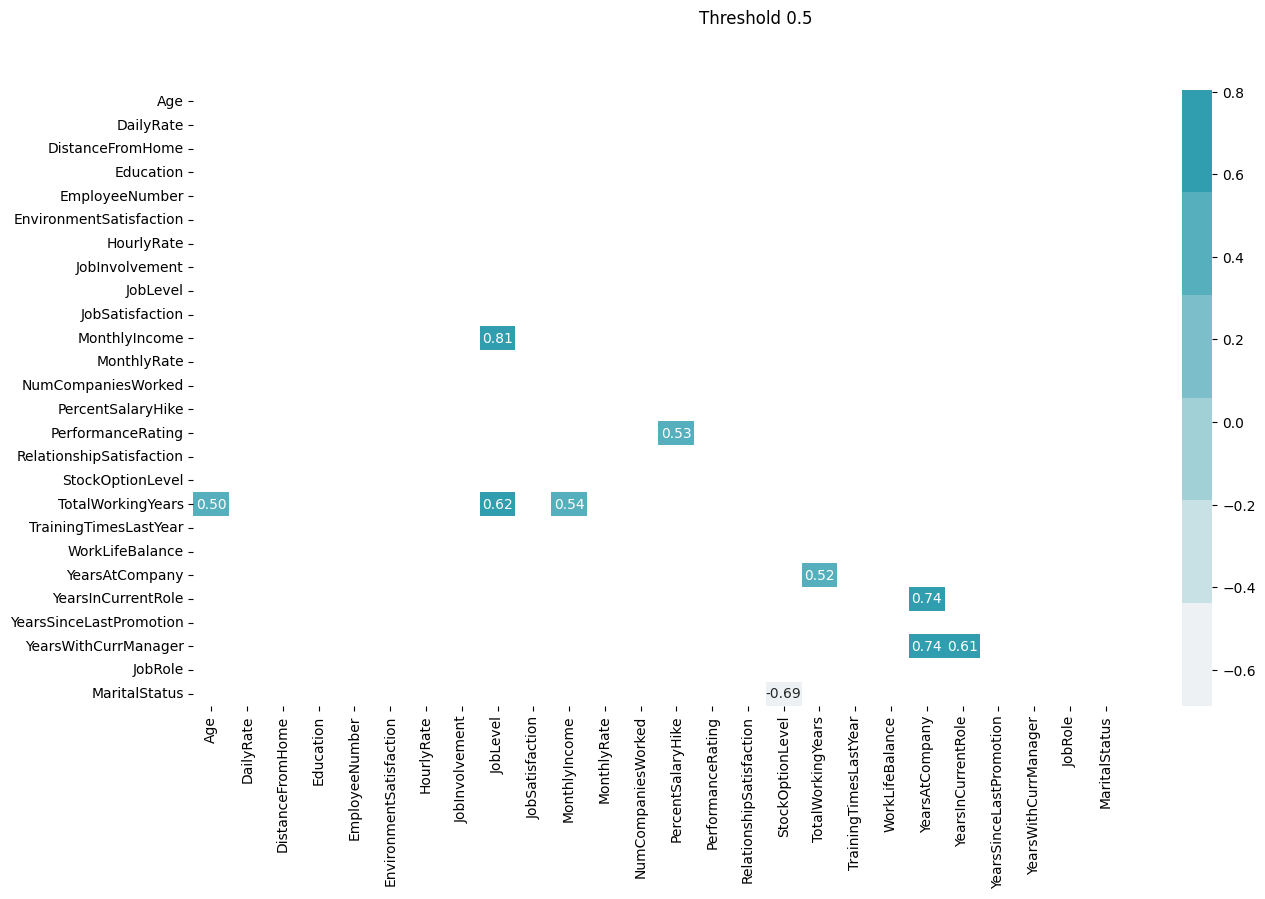

In [31]:
plot_numerical_correlation_heatmap(train_df, all_feats_list, method='kendall', threshold=0.5, figsize=(15, 8))

We observe the following correlations for Pearson, Spearman and Kendall's Tau. For Kendall's Tau we notice correlations to be smaller in general compraed to the other two methods. This is expected because it is more conservative in correlation calculation i.e., comparison-based and normalized based on pairwise concordance. However, when the values are similar that indicates a strong monotonic relation betwween the two features.

Pearson counts for linear correlations. Thus, if its value is lower than Spearman's it means that the features for some data point are monotically related but not in linear way.


| Pair | Pearson | Spearman | Kendall's Tau |
| :---- | -------: | --------: | -------------: |
| JobLevel MonthlyIncome | 0.95 | 0.92 | 0.81 |
| JobLevel TotalWorkingHours | 0.78 | 0.75 | 0.62 |
| MonthlyIncome TotalWorkingYears | 0.77 | 0.71 | 0.54 |
| PerformanceRating PercentSalaryHike | 0.77 | 0.63 | 0.54 | 
| YearsAtCompany YearsInCurentRole | 0.76 | 0.85 | 0.75 |
| YearsAtCompany YearsWithCurrManager | 0.77 | 0.84 | 0.74 |
| YearsInCurrentRole YearsWithCurrManager | 0.71 | 0.72 | 0.62 |

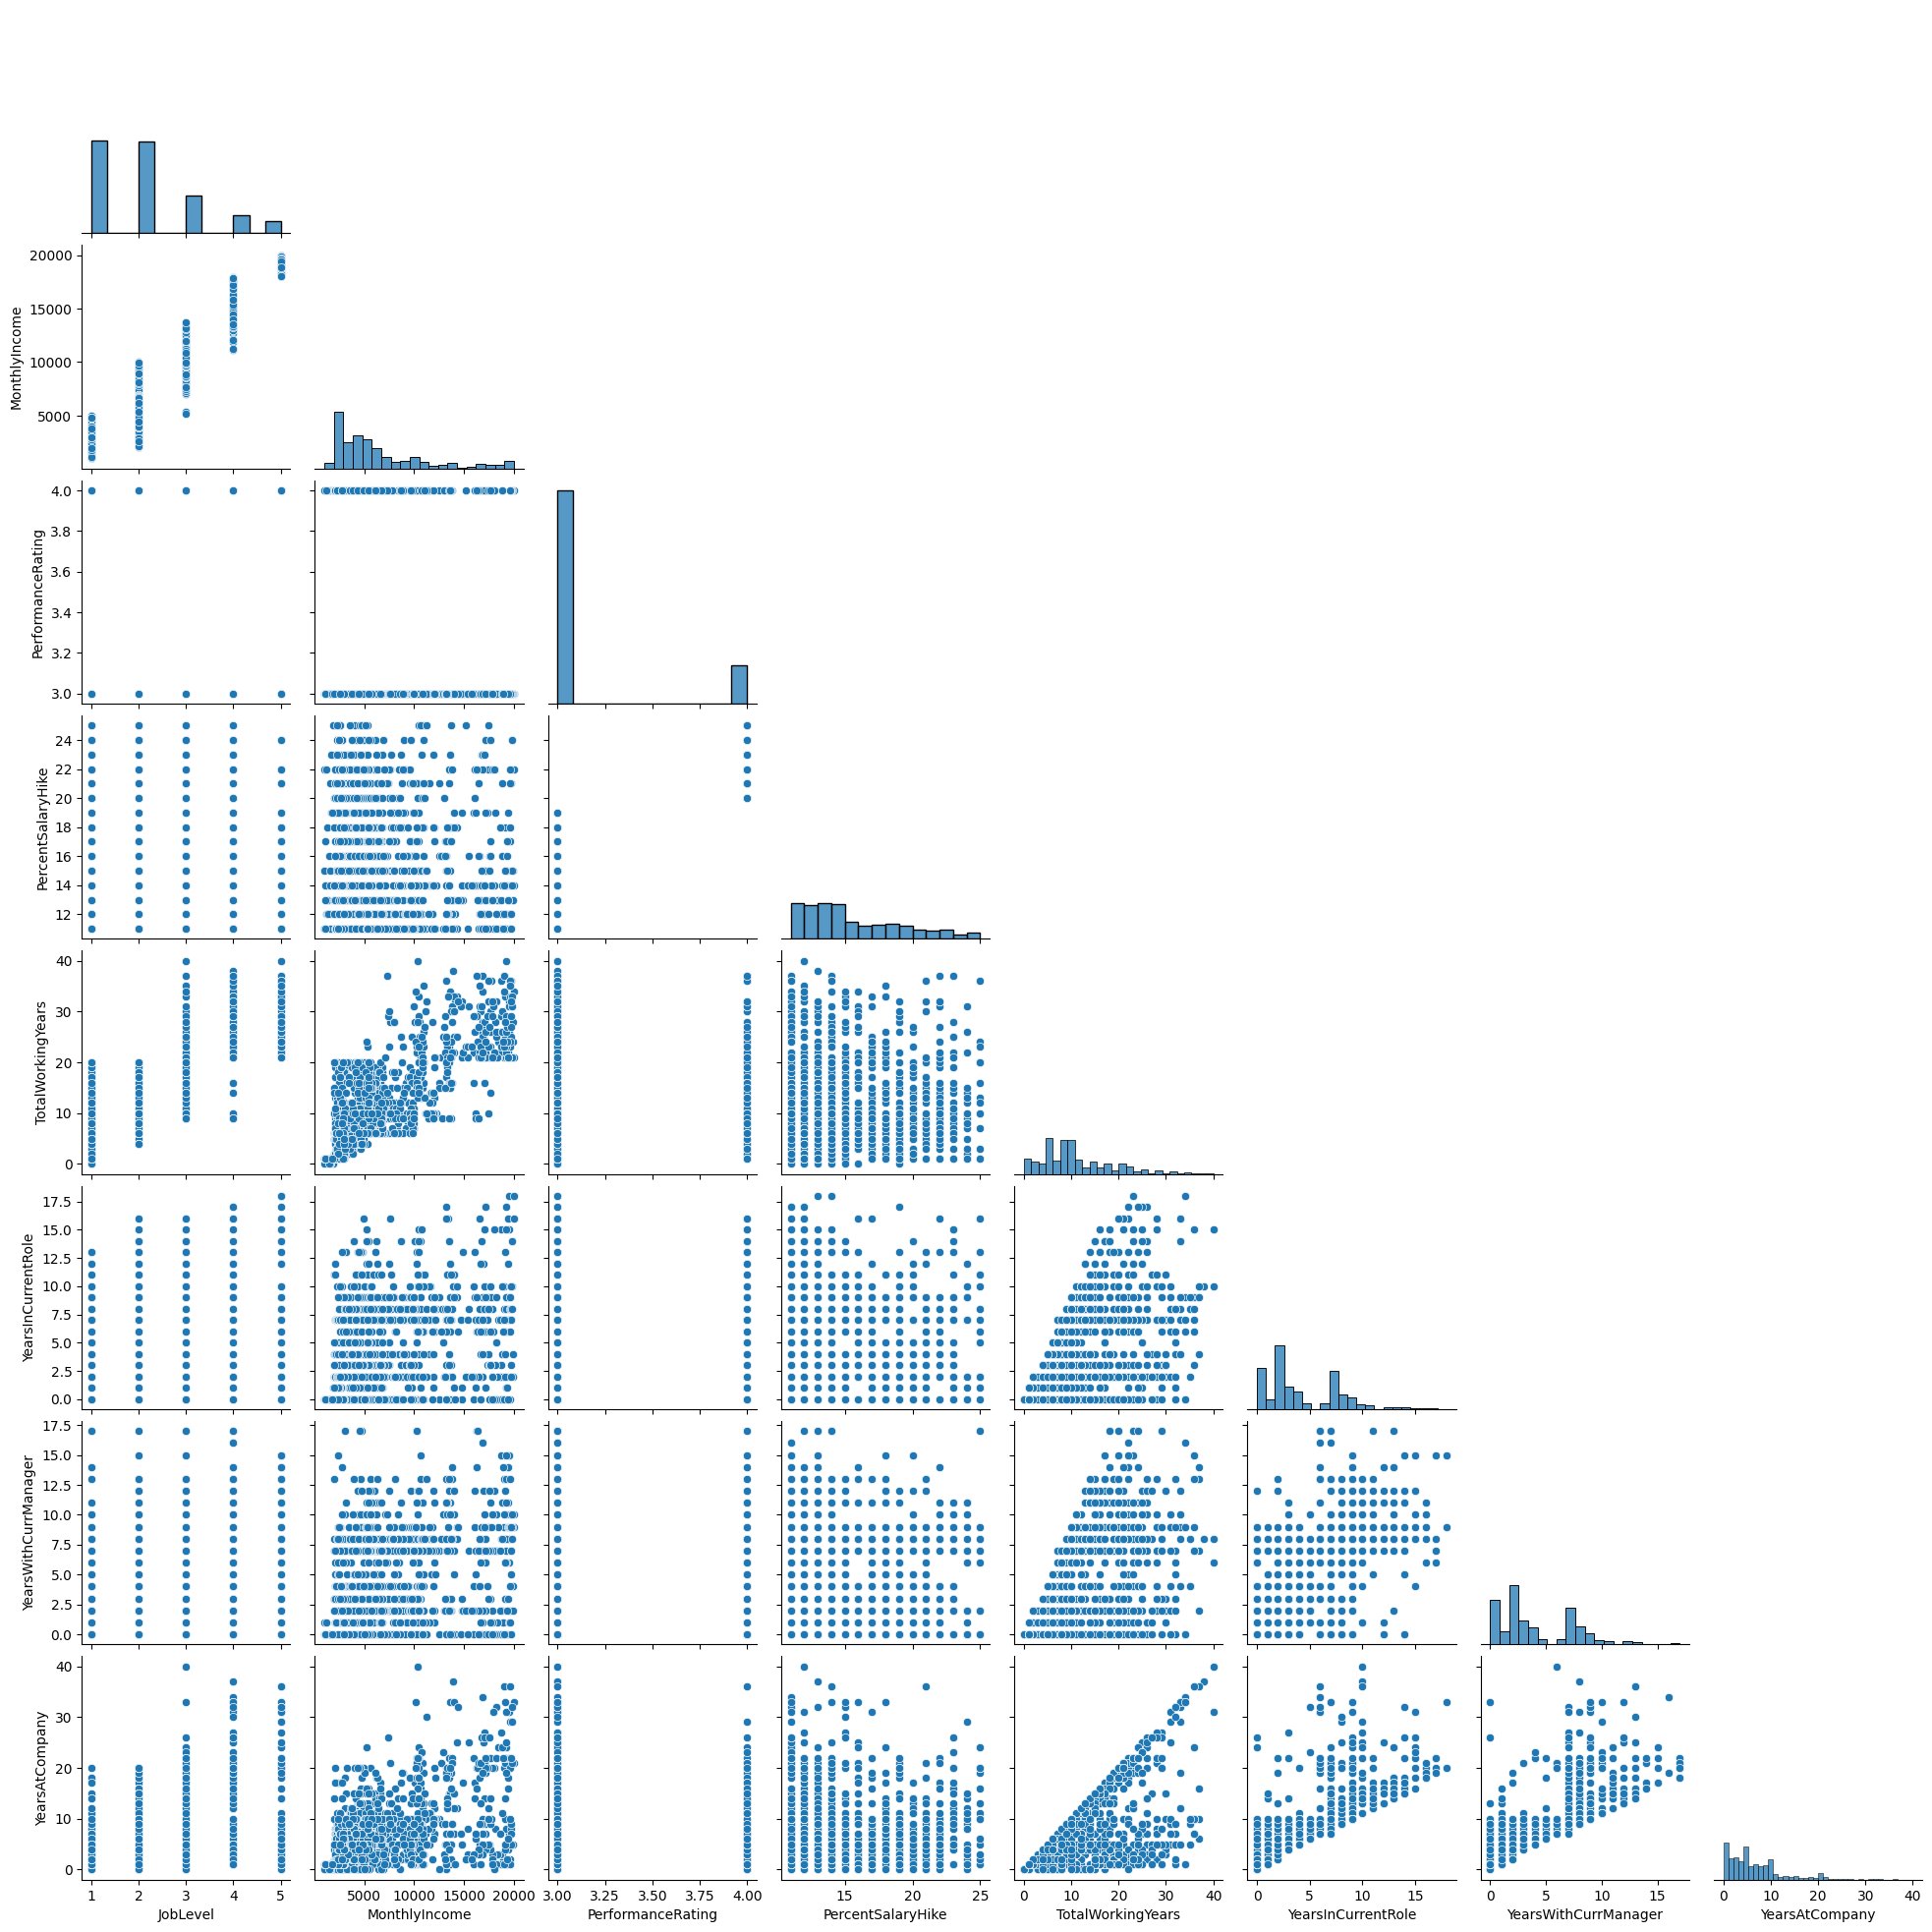

In [32]:
correlated_feats_list = ['JobLevel', 'MonthlyIncome', 'PerformanceRating', 'PercentSalaryHike', 'TotalWorkingYears'
                         , 'YearsInCurrentRole', 'YearsWithCurrManager', 'YearsAtCompany']
sns.pairplot(data_lite_df[correlated_feats_list], corner=True);

Now, let's see how the individual numeric features relate with the target feature *'Attrition'* using [Point-Biserial method](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pointbiserialr.html). The point biserial correlation is used to measure the relationship between a binary variable, x, and a continuous variable, y. Like other correlation coefficients, this one varies between -1 and +1 with 0 implying no correlation. Correlations of -1 or +1 imply a determinative relationship.

It calculates a point biserial correlation coefficient and its p-value. **Row 0 is the correlation value and row 1 is the p-value.**

For all features the correlation with attrition is weak if not existent at all. Assuming a significance level $\alpha = 0.05$ and checking the p-values (second row) we observer that for 9 out of 24 features their weak correlation with the target has no statistical signifcance. For the remainder, the p-value is less than **0.05** and thus the detected correlation is statistically significant.

Practically, there's no signifcant correlation between any numerical feature and attrition itself.

In [33]:
train_df[num_feats_list].corrwith(train_df[target], method=pointbiserialr)

,Age,DailyRate,DistanceFromHome,Education,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,-0.176,-0.066,0.072,-0.034,-0.010,-0.096,-0.003,-0.114,-0.173,-0.099,-0.164,0.034,0.038,-0.041,-0.002,-0.035,-0.130,-0.181,-0.056,-0.074,-0.142,-0.169,-0.043,-0.164
1,0.000,0.024,0.013,0.248,0.737,0.001,0.905,0.000,0.000,0.001,0.000,0.239,0.198,0.159,0.948,0.231,0.000,0.000,0.055,0.011,0.000,0.000,0.142,0.000


### Multi-colinearity

We want to make sure that none of our features is a linear combination of the others and thus they do not provide unique or independent information in case we want to apply regression modeling. To do so we use [variance inflation factor (VIF)](https://www.statology.org/how-to-calculate-vif-in-python/). VIF values $\leq 5$ are safe in general although values 1 < VIF < 5 indicate a moderate correlation.

In [34]:
vifs_df = pd.DataFrame(index=multi_cat_cols_list, columns=continuous_columns_list)
for feat in multi_cat_cols_list:
    # find design matrix for linear regression model using 'rating' as response variable 
    y, X = dmatrices(feat + ' ~ ' + '+'.join(continuous_columns_list), data=train_df, return_type='dataframe')

    # calculate VIF for each explanatory variable
    vifs_df.loc[feat, :] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])][1:]
    # vifs_df.loc[feat, :] = [variance_inflation_factor(train_df[continuous_columns_list].values, i)
    #                         for i in range(train_df[continuous_columns_list].shape[1])]

# view VIF for each explanatory variable 
vifs_df.transpose()

,BusinessTravel,Department,EducationField,JobRole,MaritalStatus
Age,1.993,1.993,1.993,1.993,1.993
DailyRate,1.011,1.011,1.011,1.011,1.011
DistanceFromHome,1.004,1.004,1.004,1.004,1.004
EmployeeNumber,1.004,1.004,1.004,1.004,1.004
HourlyRate,1.005,1.005,1.005,1.005,1.005
MonthlyIncome,2.536,2.536,2.536,2.536,2.536
MonthlyRate,1.006,1.006,1.006,1.006,1.006
PercentSalaryHike,1.007,1.007,1.007,1.007,1.007
TotalWorkingYears,4.510,4.510,4.510,4.510,4.510
YearsAtCompany,4.435,4.435,4.435,4.435,4.435


Overall the categorical variables are not associated with the continuous ones. Now, let's see how each of the continuous one is related to the others.

In [35]:
vifs_df = pd.DataFrame(index=continuous_columns_list, columns=continuous_columns_list)
for feat in continuous_columns_list:
    # find design matrix for linear regression model using 'rating' as response variable 
    y, X = dmatrices(feat + ' ~ ' + '+'.join(continuous_columns_list), data=train_df, return_type='dataframe')

    # calculate VIF for each explanatory variable
    vifs_df.loc[feat, :] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])][1:]

# view VIF for each explanatory variable 
vifs_df.transpose()

,Age,DailyRate,DistanceFromHome,EmployeeNumber,HourlyRate,MonthlyIncome,MonthlyRate,PercentSalaryHike,TotalWorkingYears,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
Age,1.993,1.993,1.993,1.993,1.993,1.993,1.993,1.993,1.993,1.993,1.993,1.993,1.993
DailyRate,1.011,1.011,1.011,1.011,1.011,1.011,1.011,1.011,1.011,1.011,1.011,1.011,1.011
DistanceFromHome,1.004,1.004,1.004,1.004,1.004,1.004,1.004,1.004,1.004,1.004,1.004,1.004,1.004
EmployeeNumber,1.004,1.004,1.004,1.004,1.004,1.004,1.004,1.004,1.004,1.004,1.004,1.004,1.004
HourlyRate,1.005,1.005,1.005,1.005,1.005,1.005,1.005,1.005,1.005,1.005,1.005,1.005,1.005
MonthlyIncome,2.536,2.536,2.536,2.536,2.536,2.536,2.536,2.536,2.536,2.536,2.536,2.536,2.536
MonthlyRate,1.006,1.006,1.006,1.006,1.006,1.006,1.006,1.006,1.006,1.006,1.006,1.006,1.006
PercentSalaryHike,1.007,1.007,1.007,1.007,1.007,1.007,1.007,1.007,1.007,1.007,1.007,1.007,1.007
TotalWorkingYears,4.510,4.510,4.510,4.510,4.510,4.510,4.510,4.510,4.510,4.510,4.510,4.510,4.510
YearsAtCompany,4.435,4.435,4.435,4.435,4.435,4.435,4.435,4.435,4.435,4.435,4.435,4.435,4.435


Again, there is no significant multi-colinearity here as well.

## Modeling

Here we will examine several potential models to predict attrition. Before anything we will transform the test data accordingly.

In [36]:
test_df = feats_test_df
test_df[target] = target_test_df
test_df.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Index: 294 entries, 442 to 1229
Columns: 32 entries, Age to Attrition
dtypes: int64(24), object(8)
memory usage: 75.8+ KB


In [37]:
test_df.head()

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
442,36,Non-Travel,635,Sales,10,4,Medical,592,2,Male,32,3,3,Sales Executive,4,Single,9980,15318,1,No,14,3,4,0,10,3,2,10,3,9,7,No
1091,33,Travel_Rarely,575,Research & Development,25,3,Life Sciences,1545,4,Male,44,2,2,Manufacturing Director,2,Single,4320,24152,1,No,13,3,4,0,5,2,3,5,3,0,2,No
981,35,Travel_Frequently,662,Sales,18,4,Marketing,1380,4,Female,67,3,2,Sales Executive,3,Married,4614,23288,0,Yes,18,3,3,1,5,0,2,4,2,3,2,Yes
785,40,Travel_Rarely,1492,Research & Development,20,4,Technical Degree,1092,1,Male,61,3,3,Healthcare Representative,4,Married,10322,26542,4,No,20,4,4,1,14,6,3,11,10,11,1,No
1332,29,Travel_Frequently,459,Research & Development,24,2,Life Sciences,1868,4,Male,73,2,1,Research Scientist,4,Single,2439,14753,1,Yes,24,4,2,0,1,3,2,1,0,1,0,Yes


In [38]:
# weight of evidence encoding for attrition
for feat in binary_cat_cols_list:
    enc = LabelEncoder()
    enc.fit(test_df[feat])
    test_df[feat] = enc.transform(test_df[feat])

test_contigency_tables_df = woe_encode_cat_feats_with_contigency_table(test_df, target, multi_cat_cols_list, verbose=True)

-> BusinessTravel  Information Value: 0.044 
classes: ['Non-Travel', 'Travel_Rarely', 'Travel_Frequently'] encoded as: ['-0.127', '-0.095', '0.410']
-> Department      Information Value: 0.042 
classes: ['Sales', 'Research & Development', 'Human Resources'] encoded as: ['0.291', '-0.143', '-0.032']
-> EducationField  Information Value: 0.067 
classes: ['Medical', 'Life Sciences', 'Marketing', 'Technical Degree', 'Other', 'Human Resources'] encoded as: ['0.067', '0.104', '0.122', '0.325', '-0.820', '-0.032']
-> JobRole         Information Value: 0.314 
classes: ['Sales Executive', 'Manufacturing Director', 'Healthcare Representative', 'Research Scientist', 'Manager', 'Laboratory Technician', 'Sales Representative', 'Human Resources', 'Research Director'] encoded as: ['0.278', '-0.032', '-1.226', '0.325', '-0.774', '0.399', '0.804', '0.073', '-0.563']
-> MaritalStatus   Information Value: 0.282 
classes: ['Single', 'Married', 'Divorced'] encoded as: ['0.686', '-0.245', '-0.674']


In [52]:
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import cross_val_score, cross_val_predict

### Decision Tree

In [40]:
clf = DecisionTreeClassifier(random_state=0)

X_train = train_df.drop(columns=target, inplace=False)
y_train = target_train_df
X_test = test_df.drop(columns=target, inplace=False)
y_test = target_test_df

In [41]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

In [46]:
train_df[target].head()
target_test_df

442      No
1091     No
981     Yes
785      No
1332    Yes
       ... 
1439     No
481      No
124     Yes
198      No
1229     No
Name: Attrition, Length: 294, dtype: object

Accuracy 1.0
ROC AUC score 1.0
              precision    recall  f1-score   support

          No       1.00      1.00      1.00       988
         Yes       1.00      1.00      1.00       188

    accuracy                           1.00      1176
   macro avg       1.00      1.00      1.00      1176
weighted avg       1.00      1.00      1.00      1176

Average Accuracy:	 0.7815
STD accuracy:		 0.0297


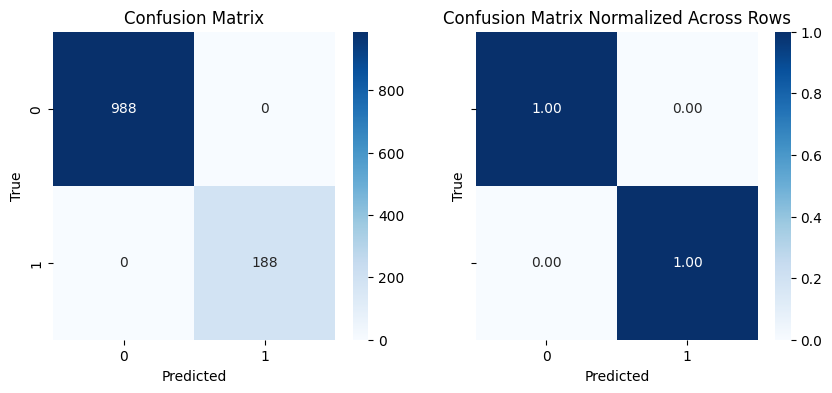

In [57]:
print('Accuracy', accuracy_score(y_train, clf.predict(X_train)))
lb = preprocessing.LabelBinarizer()
lb.fit(y_train)
print('ROC AUC score', roc_auc_score(lb.transform(y_train), lb.transform(clf.predict(X_train))))
print(classification_report(y_train, clf.predict(X_train)))
cross_validation = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
print('Average Accuracy:\t {0:.4f}'.format(np.mean(cross_validation)))
print('STD accuracy:\t\t {0:.4f}'.format(np.std(cross_validation)))

cm = confusion_matrix(y_train, clf.predict(X_train))
cm_norm = cm / cm.sum(axis=1)
rows, cols = 1, 2
figsize=(10, 4)
fig, axes = plt.subplots(rows, cols, sharey=True, figsize=figsize)

sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, ax=axes[0]);
axes[0].set_title('Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap=plt.cm.Blues, ax=axes[1]);
axes[1].set_title('Confusion Matrix Normalized Across Rows')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True');

Accuracy 0.7448979591836735
ROC AUC score 0.6020408163265306
              precision    recall  f1-score   support

          No       0.87      0.82      0.84       245
         Yes       0.30      0.39      0.34        49

    accuracy                           0.74       294
   macro avg       0.58      0.60      0.59       294
weighted avg       0.77      0.74      0.76       294

Average Accuracy:	 0.7757
STD accuracy:		 0.0599


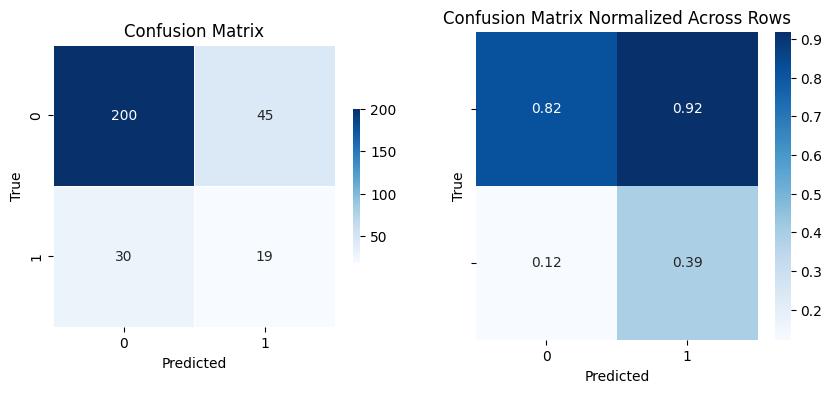

In [56]:
print('Accuracy', accuracy_score(y_test, clf.predict(X_test)))
lb = preprocessing.LabelBinarizer()
lb.fit(y_train)
print('ROC AUC score', roc_auc_score(lb.transform(y_test), lb.transform(clf.predict(X_test))))
print(classification_report(y_test, clf.predict(X_test)))
cross_validation = cross_val_score(clf, X_test, y_test, cv=10, scoring='accuracy')
print('Average Accuracy:\t {0:.4f}'.format(np.mean(cross_validation)))
print('STD accuracy:\t\t {0:.4f}'.format(np.std(cross_validation)))

cm = confusion_matrix(y_test, clf.predict(X_test))
cm_norm = cm / cm.sum(axis=1)

rows, cols = 1, 2
figsize=(10, 4)
fig, axes = plt.subplots(rows, cols, sharey=True, figsize=figsize)

sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, ax=axes[0], square=True, linewidths=.5, cbar_kws={"shrink": .5});
axes[0].set_title('Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap=plt.cm.Blues, ax=axes[1]);
axes[1].set_title('Confusion Matrix Normalized Across Rows')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True');

0.7448979591836735